In [4317]:
# Importing necessary libraries for all parts of the lab 
import numpy as np
# Provides support for large, multi-dimensional arrays and matrices.
# Useful for mathematical operations such as those needed for constructing master darks, median calculations, and image subtraction.
from scipy import stats
# Help with tasks like calculating the median or other statistical properties of the data.
from astropy.io import fits
# This is used to read and write FITS (Flexible Image Transport System) files, which is the standard format for astronomical data.
# Essential for loading the images, spectra, flat-fields, and dark frames into Python for further analysis.
from astropy.modeling import models, fitting
# Provides a framework for defining models and fitting them to data.
# Useful for tasks like wavelength calibration, where fitting a model to arc lamp spectra is needed.
import matplotlib.pyplot as plt
# A plotting library for creating visualizations such as spectra, fitted curves, and other data representations.
from numpy.polynomial import Polynomial
# Helps with creating and manipulating polynomial functions.
# Useful for tasks like fitting a polynomial to wavelength solutions or correcting for any distortions in the data.
from scipy.signal import find_peaks
# Used to identify peaks in the data, which is particularly important for finding emission or absorption lines in arc lamp spectra.
from scipy.interpolate import UnivariateSpline
from scipy.constants import h, c, k


from astropy import units as u
bb = models.BlackBody(temperature=5000*u.K)
bb(6000 * u.AA)  
# <Quantity 1.53254685e-05 erg / (Hz s sr cm2)>


from astropy.modeling.models import BlackBody

from astropy.visualization import quantity_support


In [4318]:
# 1.1
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    # Initializes an empty list to store tuples containing the header and data of each FITS file.
    for i in range(start_idx, end_idx + 1):
        # Iterates through the specified range of indices
        file_path = file_template.format(i)
        # Uses the template to create the file path for each FITS file by inserting the current index i into the placeholder.
        with fits.open(file_path) as hdul:
            # Opens the FITS file using astropy.io.fits. The with statement ensures that the file is properly closed after reading.
            # hdul (HDU list) is an object containing all the data and metadata from the FITS file.
            header = hdul[0].header
            # Extracts （提取） the header from the primary HDU (Header Data Unit).
            data = hdul[0].data
            # Extracts the image data from the primary HDU
            frames_info.append((header, data))
            # Adds a tuple containing the header and data of the current FITS file to the frames_info list.
    return frames_info # Returns a list of tuples, where each tuple represents a FITS file’s header and data.

# Allows to load multiple images quickly and efficiently, making it easier to compute the median of a series of images.

In [4319]:
def read_calibration_fits(bias_file_template, bias_start_index, bias_end_index,
                          dark_file_template, dark_start_index, dark_end_index,
                          flat_file_template, arc_lamp_file_template, start_index, end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and mercury arc lamp spectrum.

    :param bias_file_template: Template path for the bias frames with placeholders for the frame number.
    :type bias_file_template: str
    :param bias_start_index: The starting index for the bias frames.
    :type bias_start_index: int
    :param bias_end_index: The ending index for the bias frames.
    :type bias_end_index: int
    :param dark_file_template: Template path for the dark frames with placeholders for the frame number.
    :type dark_file_template: str
    :param dark_start_index: The starting index for the dark frames.
    :type dark_start_index: int
    :param dark_end_index: The ending index for the dark frames.
    :type dark_end_index: int
    :param flat_file_template: Template path for the flat field frames with placeholders for the frame number.
    :type flat_file_template: str
    :param arc_lamp_file_template: Template path for the mercury arc lamp spectrum frames with placeholders for the frame number.
    :type arc_lamp_file_template: str
    :param start_index: The starting index for both the flat fields and mercury arc lamp spectrum frames.
    :type start_index: int
    :param end_index: The ending index for both the flat fields and mercury arc lamp spectrum frames.
    :type end_index: int
    :return: A tuple containing lists of headers and data for bias frames, dark frames, flat fields, and arc lamp spectrum.
    :rtype: tuple (list of tuples, list of tuples, list of tuples, list of tuples)
    """
    bias_frames = read_fits_range(bias_file_template, bias_start_index, bias_end_index)
    dark_frames = read_fits_range(dark_file_template, dark_start_index, dark_end_index)
    flat_fields = read_fits_range(flat_file_template, start_index, end_index)
    arc_lamp_spectrum = read_fits_range(arc_lamp_file_template, start_index, end_index)

    return bias_frames, dark_frames, flat_fields, arc_lamp_spectrum

# Templates for the file names
bias_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\bias_frames_all_stars.{:08d}.BIAS.FIT"
dark_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\dark_frames_all_stars.{:08d}.DARK.FIT"
flat_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\flat_fields_all_stars_USETHIS.{:08d}.FIT"
arc_lamp_file_template = r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\arc_lamp_merc_calibration.{:08d}.FIT"

# Define the starting and ending indices
bias_start_index = 2
bias_end_index = 11
dark_start_index = 0
dark_end_index = 1
start_index = 0  # For flat fields and mercury arc lamp spectrum
end_index = 9    # For flat fields and mercury arc lamp spectrum

# Calling the function
bias_frames, dark_frames, flat_fields, arc_lamp_spectrum = read_calibration_fits(
    bias_file_template, bias_start_index, bias_end_index,
    dark_file_template, dark_start_index, dark_end_index,
    flat_file_template, arc_lamp_file_template, start_index, end_index
)


# This function is crucial for the initial data reduction steps:

# Step 1: Reading in dark frames and constructing master darks.
# Step 2: Preparing calibration frames (dark, bias, flat, and arc spectra) for subtraction and correction of science data.
# Step 3: Reading flat fields to create a master flat.
# Step 4: Preparing the arc lamp spectra for wavelength calibration.


In [4320]:
def read_spectra_fits(star_file_templates, start_index, end_index):
    """
    Read FITS files for spectral data of seven stars.

    :param star_file_templates: List of template paths for each star's spectral FITS files, with placeholders for the frame number.
    :type star_file_templates: list of str
    :param start_index: The starting index for the frames for all stars.
    :type start_index: int
    :param end_index: The ending index for the frames for all stars.
    :type end_index: int
    :return: Seven variables, each containing lists of headers and data for a star's spectra.
    :rtype: tuple of lists of tuples
    """
    # Read the spectral frames for each star
    star1_frames = read_fits_range(star_file_templates[0], start_index, end_index)
    star2_frames = read_fits_range(star_file_templates[1], start_index, end_index)
    star3_frames = read_fits_range(star_file_templates[2], start_index, end_index)
    star4_frames = read_fits_range(star_file_templates[3], start_index, end_index)
    star5_frames = read_fits_range(star_file_templates[4], start_index, end_index)
    star6_frames = read_fits_range(star_file_templates[5], start_index, end_index)
    star7_frames = read_fits_range(star_file_templates[6], start_index, end_index)

    return star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames

# Templates for each star's spectral FITS file names
star_file_templates = [
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Vega_Class_A_USETHIS.00000000.FIT",                # First star/spectrophotometric star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Vega_Class_A_USETHIS.00000001.FIT",
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Bet_Peg_M_star_Fourth_Star.{:08d}.FIT",            # Second star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Alf_Per_F_star_First_Star_USETHIS.{:08d}.FIT",     # Third star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Bet_Per_B_Class_Third_Star_USETHIS.{:08d}.FIT",    # Fourth star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Alf_Cas_K_star_Second_Star_USETHIS.{:08d}.FIT",    # Fifth star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\Alf_Aur_G_star_Fifth_Star_USETHIS.{:08d}.FIT",     # Sixth star
    r"C:\Users\sunyx\OneDrive\Documents\GitHub\AST_443\Lab_2\FITS_files\ksi_Per_O_star_Sixth_Star_USETHIS.{:08d}.FIT"      # Seventh star
]

# Define the starting and ending indices for star spectra files
start_index = 0
end_index = 1

# Calling the function to read the spectral frames
star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames = read_spectra_fits(star_file_templates, start_index, end_index)

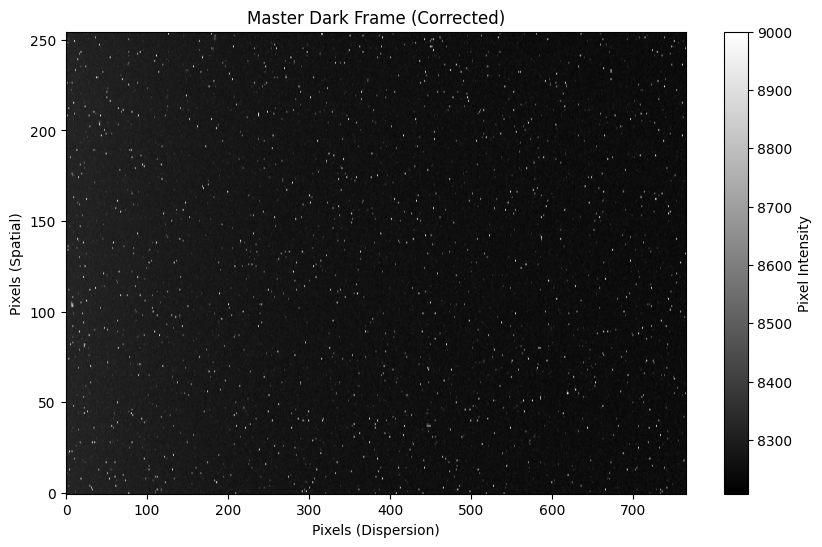

In [4321]:
def create_master_dark(dark_frames):
    """
    Create a master dark frame by median-combining the dark frames, and output the graph of the master 
    dark field with a maximum value of 9000.

    :param dark_frames: List of tuples containing headers and data for the dark FITS frames.
                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type dark_frames: list of tuples
    :return: Master dark frame after bias subtraction.
    :rtype: np.ndarray
    """

    # dark_frames: A list of tuples containing headers and data for each dark frame. 
    # Each tuple has a FITS header and a 2D numpy array (data).
    # Create the master dark frame by median-combining the dark frames
    dark_data_list = [frame[1] for frame in dark_frames]  # Extract the 'data' part from each dark frame
    master_dark = np.median(np.stack(dark_data_list), axis=0)

    # Extracts the data (2D numpy arrays) from each tuple in dark_frames.
    # Stacks these arrays into a 3D array using np.stack and calculates the median across the stack along the specified axis (axis=0), 
    # which computes the median for each pixel.
    # This process effectively reduces random noise and outliers, such as cosmic ray hits, in the combined master dark frame.

    # Filter the master dark frame
    master_dark[master_dark > 9000] = 9000  # Clamp values above 9000
    # Plotting the master dark frame with a maximum value of 9000
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame (Corrected)')
    plt.grid(False)
    plt.show()

    return master_dark

# Example call to the function 
master_dark_corrected = create_master_dark(dark_frames)
# This line calls the function using dark_frames (assumed to be already loaded) and creates a corrected master dark frame.
# The resulting master_dark_corrected can be used in further data reduction, 
# such as subtracting it from science frames to remove consistent dark noise.
# This function produces a clean master dark frame by combining multiple individual dark frames, 
# reducing noise and cosmic ray artifacts. 
# The visualization step helps ensure that the master dark looks as expected before applying it to other images.

In [4322]:
def create_median_images(spectra_frames, master_dark_corrected, row_start=0, row_end=110):
    """
    Subtract the master dark frame from each star's frames, crop the y-axis to the specified spectral region,
    and compute the median image for each star.

    :param spectra_frames: A tuple containing lists of headers and data for each star's spectra.
                           Each list contains tuples of (header, data), where `data` is a 2D numpy array.
    :type spectra_frames: tuple of lists of tuples
    :param master_dark_corrected: The master dark frame to be subtracted.
    :type master_dark_corrected: np.ndarray
    :param row_start: The starting index for the row range (y-axis) to crop the image.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the image.
    :type row_end: int
    :return: A list of median images for each star after dark subtraction and cropping.
    :rtype: list of np.ndarray
    """
    median_images = []
    # Creates an empty list median_images to store the median image for each star.
    # Subtract the master dark from each star's frames, crop the spectral region, and compute the median
    for frames in spectra_frames:
    # Looping Through Stars: For each star’s list of frames (frames):
    # Extracts the data from each frame (2D numpy arrays) into star_data_list.
        star_data_list = [frame[1] for frame in frames]  # Extract the 'data' part from each star frame
        corrected_images = [data - master_dark_corrected for data in star_data_list]  # Subtract the master dark
        # Dark Subtraction:
        # Subtracts the master_dark_corrected frame from each 2D array (image) in star_data_list, removing dark noise.

        cropped_images = [img[row_start:row_end, :] for img in corrected_images]  # Crop the y-axis
        # Cropping:
        # Crops the images along the y-axis from row_start to row_end to focus on the specific spectral region of interest, 
        # ignoring parts of the image outside this range.

        # Compute the median image for the cropped spectral region
        median_image = np.median(np.stack(cropped_images), axis=0)
        median_images.append(median_image)
        # Median Combination:
        # Uses np.median with np.stack to combine the cropped images, taking the median at each pixel location along the stack.
        # This reduces noise further and produces a clean spectral image for each star.
        # Store the Result:
        # Appends the median image for the current star to median_images.

    return median_images

# Example call to the function
spectra_frames = (star1_frames, star2_frames, star3_frames, star4_frames, star5_frames, star6_frames, star7_frames)
median_images = create_median_images(spectra_frames, master_dark_corrected)
# Call uses the spectra_frames tuple, which contains data for all seven stars, and the master_dark_corrected frame.
# It produces a list of median images, where each image corresponds to a star and represents its spectrum after dark subtraction and cropping.

# Dark Subtraction: Removes unwanted noise from each spectral frame using the master dark.
# Cropping: Focuses the analysis on a specific y-range that corresponds to the illuminated region of interest.
# Median Combination: Reduces noise and artifacts by taking the median of multiple exposures, resulting in a clearer spectral image.


# Optional: Plot the cropped median images for each star
# for i, median_image in enumerate(median_images):
    # plt.figure(figsize=(10, 6))
    # plt.imshow(median_image, cmap='gray', origin='lower', aspect='auto')
    # plt.colorbar(label='Pixel Intensity')
    # plt.title(f'Cropped Median Image for Star {i+1} (Rows {0} to {110})')
    # plt.xlabel('Pixels (Dispersion)')
    # plt.ylabel('Pixels (Spatial)')
    # plt.grid(False)
    # plt.show()

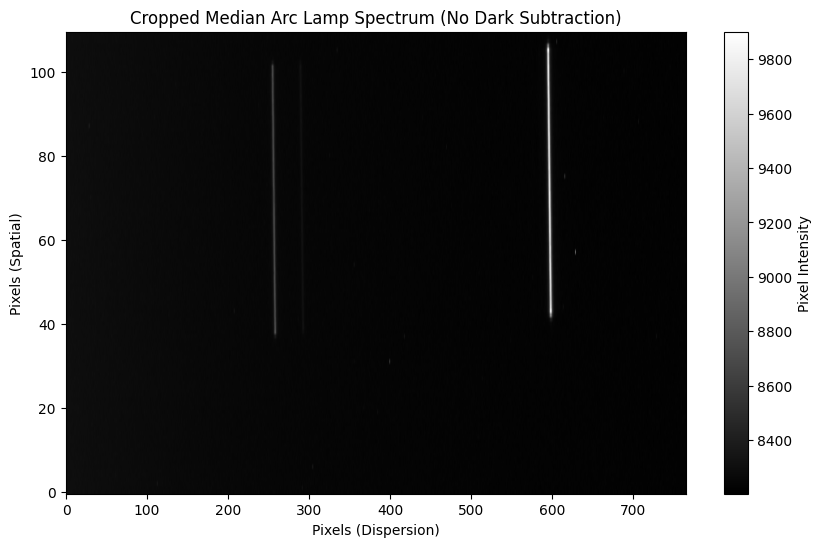

In [4323]:
def create_median_arc_spectrum(arc_lamp_spectrum, row_start=0, row_end=110):
    """
    Compute the median arc lamp spectrum by cropping the y-axis to the specified spectral region 
    without subtracting the master dark frame.

    :param arc_lamp_spectrum: List of tuples containing headers and data for the arc lamp spectrum.
                              Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type arc_lamp_spectrum: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the spectrum.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the spectrum.
    :type row_end: int
    :return: Median arc lamp spectrum after cropping.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each arc lamp frame
    arc_data_list = [frame[1] for frame in arc_lamp_spectrum]
    # Crop the y-axis of each arc lamp frame
    cropped_arc_data_list = [data[row_start:row_end, :] for data in arc_data_list]
    # Compute the median of the cropped arc lamp spectra (no dark subtraction)
    median_arc_spectrum = np.median(np.stack(cropped_arc_data_list), axis=0)
    return median_arc_spectrum

# Calling the function
median_arc_spectrum = create_median_arc_spectrum(arc_lamp_spectrum)

# Optional: Plot the median arc lamp spectrum
plt.figure(figsize=(10, 6))
plt.imshow(median_arc_spectrum, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Cropped Median Arc Lamp Spectrum (No Dark Subtraction)')
plt.grid(False)
plt.show()


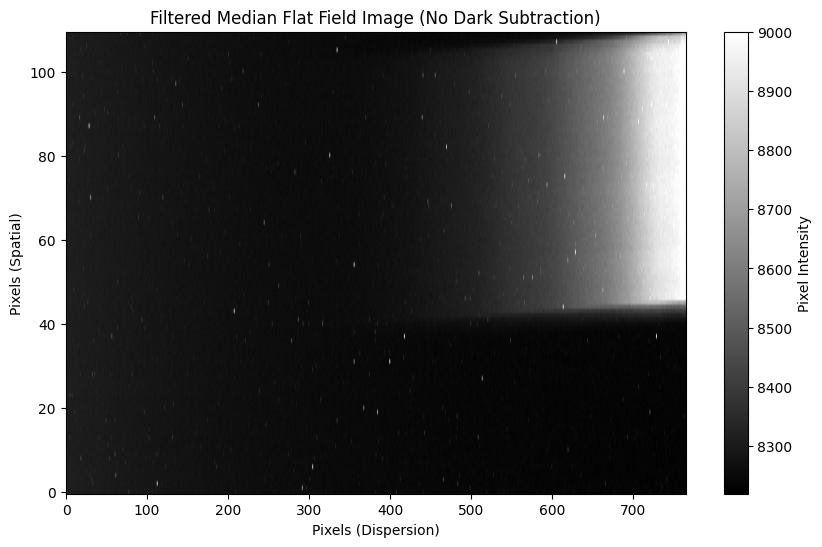

In [4324]:
# 1.2

def median_flat_field(flat_fields, row_start=0, row_end=110):
    """
    Compute the median flat field image without subtracting the master dark frame,
    crop the y-axis to the specified region, and clamp values above 9000.

    :param flat_fields: List of tuples containing headers and 2D numpy array data for flat field frames.
    :type flat_fields: list of tuples
    :param row_start: The starting index for the row range (y-axis) to crop the flat fields.
    :type row_start: int
    :param row_end: The ending index for the row range (y-axis) to crop the flat fields.
    :type row_end: int
    :return: The median flat field image cropped to the specified region and filtered.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each flat field frame and crop the y-axis
    flat_field_data_list = [frame[1][row_start:row_end, :] for frame in flat_fields]
    # Create the median flat field image from the flat fields (no dark subtraction)
    median_flat_field_image = np.median(np.stack(flat_field_data_list), axis=0)
    # Clamp values above 9000
    median_flat_field_image[median_flat_field_image > 9000] = 9000
    
    return median_flat_field_image

# Calling the function
median_flat_field_image = median_flat_field(flat_fields)

# Optional: Plotting the filtered median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(median_flat_field_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Filtered Median Flat Field Image (No Dark Subtraction)')
plt.grid(False)
plt.show()

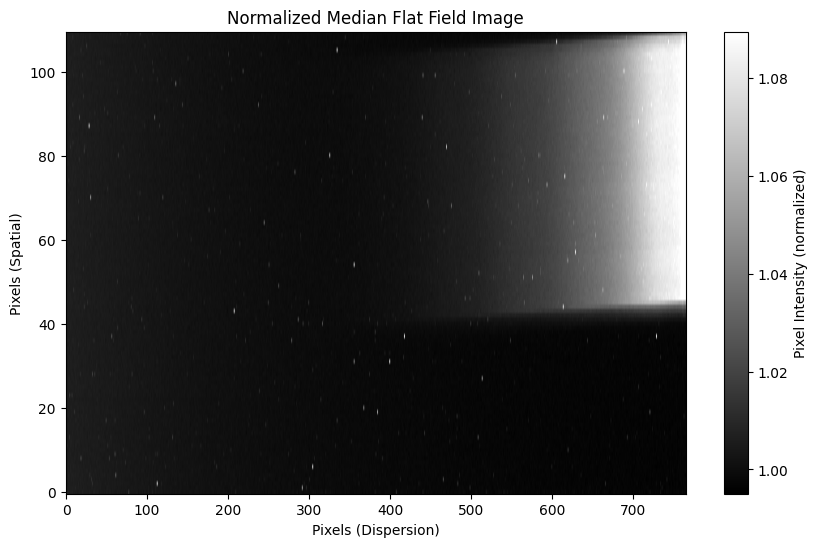

In [4325]:
def normalize_flat_field(median_flat_field_image):
    """
    Normalize the median flat field image by dividing it by its mode.

    :param median_flat_field_image: The median flat field image to be normalized.
    :type median_flat_field_image: np.ndarray
    :return: The normalized median flat field image.
    :rtype: np.ndarray
    """
    # Calculate the mode for normalization
    mode_value = stats.mode(median_flat_field_image, axis=None, keepdims=True).mode[0]
    # Normalize the median flat field by dividing by its mode
    if mode_value != 0:  # Avoid division by zero
        normalized_flat_field = median_flat_field_image / mode_value
    else:
        print("Mode value is zero, skipping normalization.")
        normalized_flat_field = median_flat_field_image

    return normalized_flat_field

# Calling the function 
normalized_flat_field_image = normalize_flat_field(median_flat_field_image)

# Optional: Plotting the normalized median flat field image
plt.figure(figsize=(10, 6))
plt.imshow(normalized_flat_field_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity (normalized)')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Normalized Median Flat Field Image')
plt.grid(False)
plt.show()

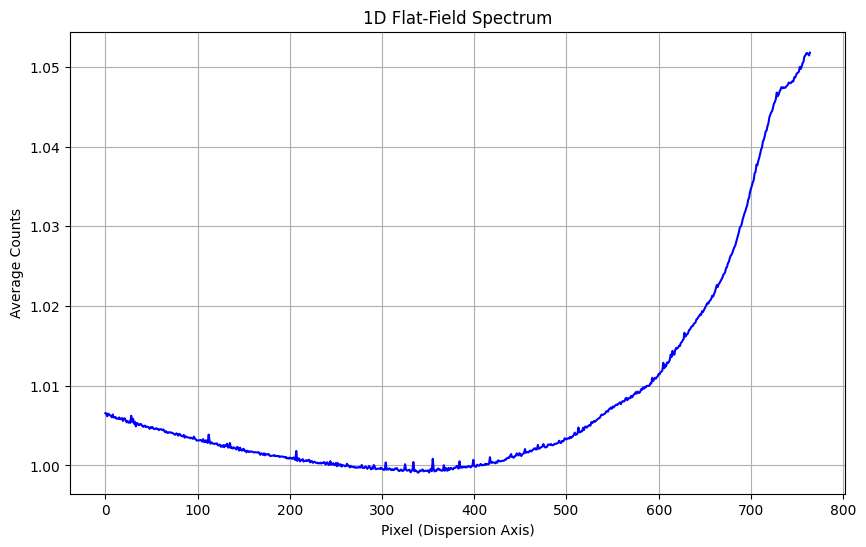

In [4326]:
# 1.3

def collapse_flat_field_1d(normalized_flat_field_image):
    """
    Collapse the 2D normalized flat field image to a 1D spectrum
    by averaging the counts in each column.

    :param normalized_flat_field_image: The normalized median flat field image.
    :type normalized_flat_field_image: np.ndarray
    :return: 1D array of averaged counts.
    :rtype: np.ndarray
    """
    # Collapse the 2D image to a 1D array by taking the mean of each column
    flat_1d = np.mean(normalized_flat_field_image, axis=0)
    # Plot the 1D flat-field values against pixel positions
    plt.figure(figsize=(10, 6))
    plt.plot(flat_1d, color='blue')
    plt.title('1D Flat-Field Spectrum')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Average Counts')
    plt.grid(True)
    plt.show()

    return flat_1d

# Calling the function
flat_1d = collapse_flat_field_1d(normalized_flat_field_image)

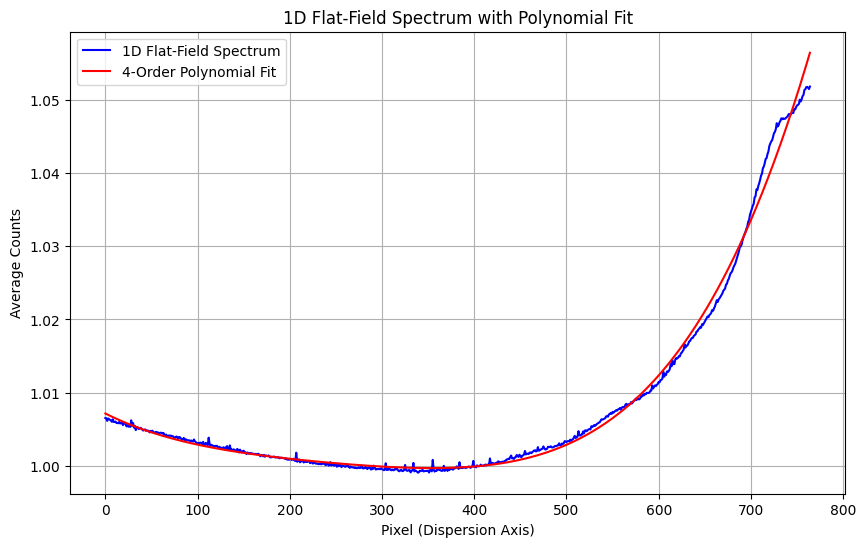

In [4327]:
def fit_polynomial_to_flat_field(flat_1d, degree=4):
    """
    Fit a polynomial to the 1D flat-field spectrum and plot the results.

    :param flat_1d: The 1D array of averaged counts from the flat-field image.
    :type flat_1d: np.ndarray
    :param degree: The degree of the polynomial to fit (default is 4).
    :type degree: int
    :return: Coefficients of the fitted polynomial.
    :rtype: np.ndarray
    """
    # Fit a polynomial to the 1D flat-field data
    x_axis = np.arange(len(flat_1d))
    polynomial_fit = Polynomial.fit(x_axis, flat_1d, deg=degree)
    # Evaluate the polynomial fit
    fit_values = polynomial_fit(x_axis)
    # Plot the 1D flat-field values and the polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(flat_1d, label='1D Flat-Field Spectrum', color='blue')
    plt.plot(fit_values, label=f'{degree}-Order Polynomial Fit', color='red')
    plt.title('1D Flat-Field Spectrum with Polynomial Fit')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Average Counts')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the polynomial coefficients
    return polynomial_fit.convert().coef

# Example call
polynomial_coefficients = fit_polynomial_to_flat_field(flat_1d)

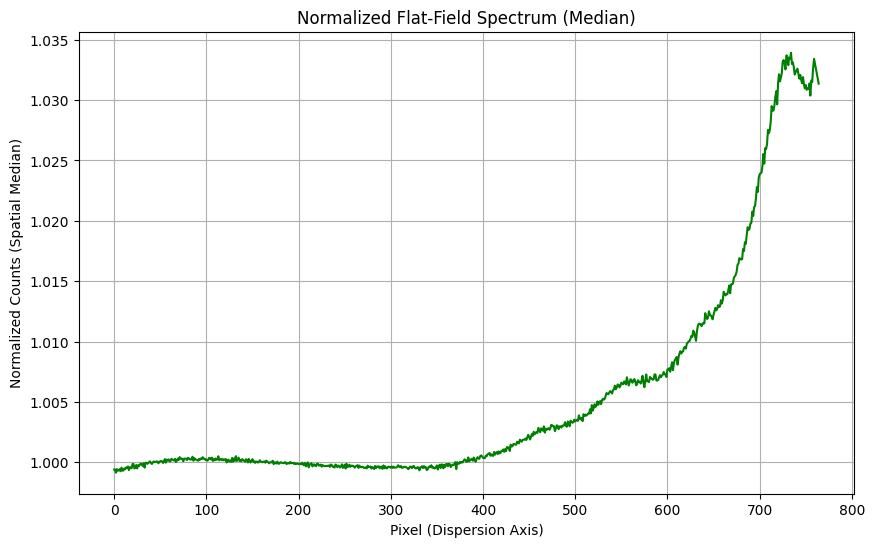

In [4328]:
def normalize_flat_field_2d(normalized_flat_field_image, polynomial_coefficients):
    """
    Normalize the 2D flat-field image by dividing each row by the fitted polynomial.

    :param normalized_flat_field_image: The 2D array representing the normalized flat-field image.
    :type normalized_flat_field_image: np.ndarray
    :param polynomial_coefficients: Coefficients of the fitted polynomial.
    :type polynomial_coefficients: np.ndarray
    :return: The normalized flat-field image.
    :rtype: np.ndarray
    """
    # Generate the x-axis corresponding to the columns of the flat field
    x_axis = np.arange(normalized_flat_field_image.shape[1])
    # Evaluate the polynomial fit at each x position
    polynomial_fit_values = Polynomial(polynomial_coefficients)(x_axis)
    # Normalize the flat field by dividing each row by the polynomial fit values
    normalized_flat_field_poly = normalized_flat_field_image / polynomial_fit_values
    # Handle potential division by zero or NaN values
    normalized_flat_field_poly[np.isnan(normalized_flat_field_poly)] = 0  # Set NaNs to zero
    normalized_flat_field_poly[np.isinf(normalized_flat_field_poly)] = 0  # Set Infs to zero

    # Plot the median normalized flat field along the dispersion axis
    plt.figure(figsize=(10, 6))
    plt.plot(np.median(normalized_flat_field_poly, axis=0), color='green')
    plt.title('Normalized Flat-Field Spectrum (Median)')
    plt.xlabel('Pixel (Dispersion Axis)')
    plt.ylabel('Normalized Counts (Spatial Median)')
    plt.grid(True)
    plt.show()

    return normalized_flat_field_poly

# Example call
normalized_flat_field_poly = normalize_flat_field_2d(normalized_flat_field_image, polynomial_coefficients)

In [4329]:
def correct_science_images(spectra_frames, normalized_flat_field_from_polynomial, row_start=0, row_end=110):
    """
    Correct each science image by dividing it by the normalized flat field from polynomial fitting
    and cropping the spectra frames.

    :param spectra_frames: A tuple containing lists of headers and data for each star's spectra.
                          Each list contains tuples of (header, data).
    :type spectra_frames: tuple of lists of tuples
    :param normalized_flat_field_from_polynomial: The normalized 2D flat-field image to divide by.
    :type normalized_flat_field_from_polynomial: np.ndarray
    :param row_start: Starting row index for cropping.
    :type row_start: int
    :param row_end: Ending row index for cropping.
    :type row_end: int
    :return: A list of corrected and cropped science images for each star.
    :rtype: list of np.ndarray
    """
    corrected_images = []
    # Iterate over each star's frames
    for frames in spectra_frames:
        # Extract the 'data' part from each star frame
        star_data_list = [frame[1] for frame in frames]  
        # Calculate the median image across the star data
        median_star_image = np.median(star_data_list, axis=0)
        # Divide the median star image by the normalized flat field and crop the image
        corrected_image = median_star_image[row_start:row_end, :] / normalized_flat_field_from_polynomial
        corrected_images.append(corrected_image)

    return corrected_images

# Calling the function 
corrected_spectra_images = correct_science_images(spectra_frames, normalized_flat_field_poly)

# Optional: Plotting the corrected images for each star
# for star_index, corrected_image in enumerate(corrected_spectra_images):
    # plt.figure(figsize=(10, 6))
    # plt.imshow(corrected_image, cmap='gray', origin='lower', aspect='auto')
    # plt.colorbar(label='Flux')
    # plt.title(f'Corrected Image for Star {star_index + 1}')
    # plt.xlabel('Pixels (Dispersion)')
    # plt.ylabel('Pixels (Spatial)')
    # plt.grid(False)
    # plt.show()

Corrected median arc spectrum saved to corrected_median_arc_spectrum.fits


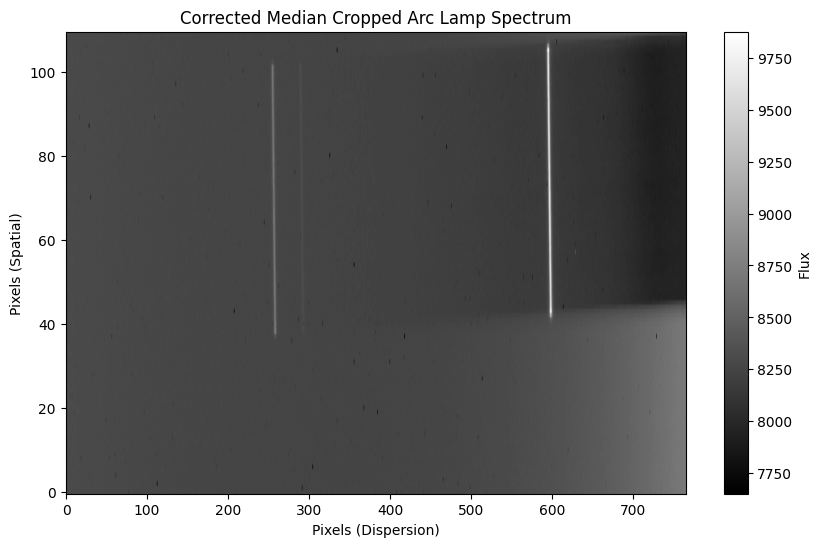

In [4330]:
def correct_arc_lamp_spectrum(arc_lamp_spectrum, normalized_flat_field_from_polynomial, row_start=0, row_end=110, output_filename='corrected_median_arc_spectrum.fits'):
    """
    Correct the arc lamp spectrum by taking the median of the cropped spectra frames
    and dividing by the normalized flat field from polynomial fitting.

    :param arc_lamp_spectrum: A list containing tuples of (header, data) for the arc lamp frames.
    :type arc_lamp_spectrum: list of tuples
    :param normalized_flat_field_from_polynomial: The normalized 2D flat-field image to divide by.
    :type normalized_flat_field_from_polynomial: np.ndarray
    :param row_start: Starting row index for cropping.
    :type row_start: int
    :param row_end: Ending row index for cropping.
    :type row_end: int
    :param output_filename: Name of the output FITS file.
    :type output_filename: str
    :return: The corrected median arc lamp spectrum.
    :rtype: np.ndarray
    """
    # Extract the 'data' part from each arc lamp frame
    arc_data_list = [frame[1] for frame in arc_lamp_spectrum]
    # Crop the y-axis of each arc lamp frame
    cropped_arc_data_list = [data[row_start:row_end, :] for data in arc_data_list]
    # Compute the median of the cropped arc lamp spectra (no dark subtraction)
    median_arc_spectrum = np.median(np.stack(cropped_arc_data_list), axis=0)
    # Divide the median arc spectrum by the normalized flat field
    corrected_median_arc_spectrum = median_arc_spectrum / normalized_flat_field_from_polynomial
    
    # Save the corrected median arc spectrum to a FITS file
    hdu = fits.PrimaryHDU(corrected_median_arc_spectrum)
    hdu.writeto(output_filename, overwrite=True)
    print(f"Corrected median arc spectrum saved to {output_filename}")

    return corrected_median_arc_spectrum

# Calling the function
corrected_median_arc_image = correct_arc_lamp_spectrum(arc_lamp_spectrum, normalized_flat_field_poly)

# Optional: Plotting the corrected median arc lamp spectrum
plt.figure(figsize=(10, 6))
plt.imshow(corrected_median_arc_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Flux')
plt.title('Corrected Median Cropped Arc Lamp Spectrum')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.grid(False)
plt.show()

In [4331]:
# 1.4

def extract_target_sky_flux(corrected_image, 
                              target_row_start=0, target_row_end=110, 
                              sky_row_start=40, sky_row_end=60):
    """
    Extract the target and sky flux from the corrected spectra image and compute the 1D spectrum.

    :param corrected_image: The corrected and cropped science image.
    :type corrected_image: np.ndarray
    :param target_row_start: The starting row index for the target region.
    :type target_row_start: int
    :param target_row_end: The ending row index for the target region.
    :type target_row_end: int
    :param sky_row_start: The starting row index for the sky region.
    :type sky_row_start: int
    :param sky_row_end: The ending row index for the sky region.
    :type sky_row_end: int
    :return: The 1D object flux and sky flux.
    :rtype: tuple of np.ndarray
    """
    # Crop target and sky regions using the new row_start and row_end variables
    target_region = corrected_image[target_row_start:target_row_end, :]
    sky_region = corrected_image[sky_row_start:sky_row_end, :]
    # Sum the flux in the target and sky regions along the spatial axis (rows)
    target_flux = np.sum(target_region, axis=0)
    sky_flux = np.mean(sky_region, axis=0)  # Average sky background across rows
    # Subtract sky background from target flux
    object_flux = target_flux - sky_flux
    
    return object_flux, sky_flux

In [4332]:
def calculate_poisson_uncertainties(object_flux, sky_flux):
    """
    Calculate Poisson uncertainties for the object flux using scipy.stats.poisson.

    :param object_flux: The 1D array of object flux.
    :type object_flux: np.ndarray
    :param sky_flux: The 1D array of sky flux.
    :type sky_flux: np.ndarray
    :return: The 1D array of Poisson uncertainties.
    :rtype: np.ndarray
    """
    # Poisson uncertainties directly from the object and sky flux
    object_poisson = np.sqrt(np.clip(object_flux, 0, None))  # Poisson uncertainty for object flux
    sky_poisson = np.sqrt(np.clip(sky_flux, 0, None))        # Poisson uncertainty for sky flux
    # Total uncertainty from object and sky Poisson distributions
    total_uncertainties = np.sqrt(object_poisson**2 + sky_poisson**2)
    
    return total_uncertainties

# Process each star's corrected spectra image individually
for i, corrected_image in enumerate(corrected_spectra_images):
    object_flux, sky_flux = extract_target_sky_flux(corrected_image)
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)


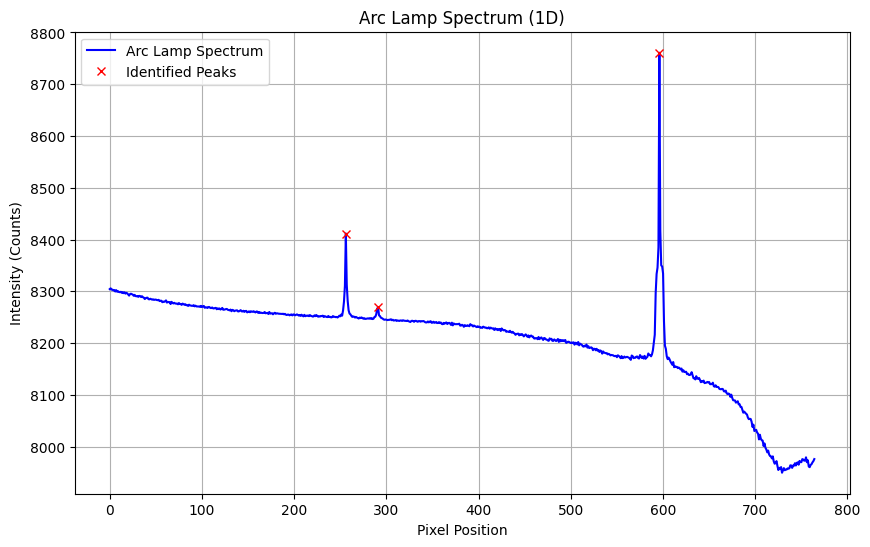

In [4333]:
def analyze_arc_lamp_spectrum(corrected_median_arc_image, height_threshold=112, prominence_threshold=20):
    """
    Analyze the corrected arc lamp spectrum by collapsing it to 1D,
    identifying peaks based on height and prominence, and plotting the resulting spectrum.

    :param corrected_median_arc_image: 2D array containing the corrected arc lamp spectrum.
    :type corrected_median_arc_image: np.ndarray
    :param height_threshold: The height threshold for identifying peaks in the spectrum (default is 112).
    :type height_threshold: int, optional
    :param prominence_threshold: The minimum prominence for peaks (default is 20: DON'T CHANGE THIS).
    :type prominence_threshold: int, optional
    :return: 1D array of the arc lamp spectrum and indices of identified peaks.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Collapse the 2D arc lamp spectrum to 1D by taking the median along the spatial axis
    arc_lamp_spectrum_1d = np.median(corrected_median_arc_image, axis=0)
    # Identify peaks in the arc lamp spectrum using specified thresholds
    peak_indices, properties = find_peaks(arc_lamp_spectrum_1d, height=height_threshold, prominence=prominence_threshold)
    
    # Plot the arc lamp spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(arc_lamp_spectrum_1d, label='Arc Lamp Spectrum', color='blue')
    plt.plot(peak_indices, arc_lamp_spectrum_1d[peak_indices], 'rx', label='Identified Peaks')
    # Customize plot appearance
    plt.title('Arc Lamp Spectrum (1D)')
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid()
    plt.show()

    return arc_lamp_spectrum_1d, peak_indices

# Calling the function
arc_lamp_spectrum_1d, peak_indices = analyze_arc_lamp_spectrum(corrected_median_arc_image)

In [4334]:
def print_peak_positions_with_intensities(arc_lamp_spectrum_1d, peak_indices):
    """
    Retrieve the pixel positions and corresponding intensities of the identified peaks in the 
    arc lamp spectrum.

    :param arc_lamp_spectrum_1d: 1D array containing the arc lamp spectrum.
    :type arc_lamp_spectrum_1d: np.ndarray
    :param peak_indices: 1D array containing the indices of the identified peaks.
    :type peak_indices: np.ndarray
    :return: A tuple of the peak pixel indices and corresponding intensities.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Extract the peak intensities at the identified peak indices
    peak_intensities = arc_lamp_spectrum_1d[peak_indices]
    return peak_indices, peak_intensities

# Calling the function
peak_indices, peak_intensities = print_peak_positions_with_intensities(arc_lamp_spectrum_1d, peak_indices)

# Displaying the results
for idx, intensity in zip(peak_indices, peak_intensities):
    print(f"Peak at pixel {idx}: Intensity = {intensity}")

Peak at pixel 256: Intensity = 8411.624934808797
Peak at pixel 291: Intensity = 8268.715134955431
Peak at pixel 596: Intensity = 8760.84841307697


Pixel Position | Wavelength (nm)
------------------------------
            256 |          365.02
            291 |          404.66
            596 |          435.83


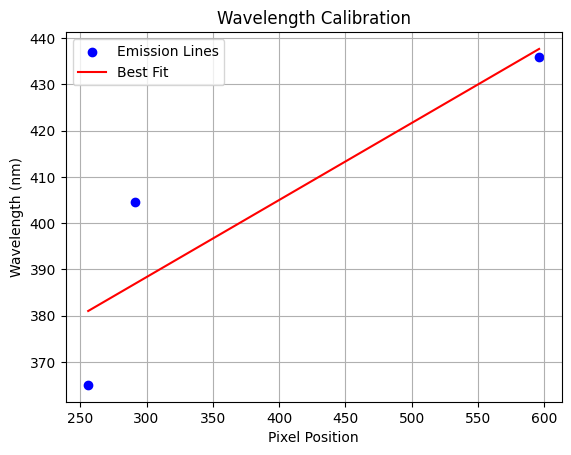

Linear Coefficients: Slope = 0.1666411722659044 nm, Intercept = 338.34638003335715 nm


In [4335]:
def fit_wavelengths_to_peaks(peak_indices):
    """
    Fit the identified peak indices to known wavelengths, outputs table of pixel positions 
    and their wavelengths, and generates a calibration graph, returning the model coefficients.
    
    :param peak_indices: 1D array containing the indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    :return: A tuple containing the coefficients of the linear fit (slope, intercept).
    :rtype: tuple(float, float)
    """
    # Known wavelengths corresponding to the identified peaks in nanometers
    known_wavelengths = [365.02, 404.66, 435.83]
    # Ensure the number of peaks matches the number of known wavelengths
    if len(peak_indices) != len(known_wavelengths):
        raise ValueError("Number of identified peaks does not match the number of known wavelengths.")
    # Fit a linear model to the data
    linear_model = models.Linear1D()
    fitter = fitting.LinearLSQFitter()
    # Perform the fitting
    best_fit = fitter(linear_model, peak_indices, known_wavelengths)
    # Generate the table of pixel positions and wavelengths
    print("Pixel Position | Wavelength (nm)")
    print("-" * 30)
    for pixel_position, wavelength in zip(peak_indices, known_wavelengths):
        print(f"{pixel_position:15d} | {wavelength:15.2f}")

    # Plot the data and the best-fit linear line
    plt.scatter(peak_indices, known_wavelengths, color='blue', label='Emission Lines')
    plt.plot(np.sort(peak_indices), best_fit(np.sort(peak_indices)), color='red', label='Best Fit')
    plt.xlabel('Pixel Position')
    plt.ylabel('Wavelength (nm)')
    plt.title('Wavelength Calibration')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Output the linear coefficients
    coefficients = (best_fit.slope.value, best_fit.intercept.value)
    print(f"Linear Coefficients: Slope = {coefficients[0]} nm, Intercept = {coefficients[1]} nm")
    
    return coefficients

# Calling the function 
coefficients = fit_wavelengths_to_peaks(peak_indices)

In [4336]:
def convert_dispersion_to_nanometers(object_flux, coefficients):
    """
    Convert the x-axis of the object flux from counts to nanometers.

    :param object_flux: 1D array containing the object flux (in intensity/counts).
    :type object_flux: np.ndarray
    :param coefficients: Coefficients of the linear fit for the conversion to nanometers.
    :type coefficients: tuple
    :return: wavelengths in nanometers and the converted object flux.
    :rtype: tuple (np.ndarray, np.ndarray)
    """
    # Extract linear coefficients: slope (a) and intercept (b)
    slope, intercept = coefficients  
    # Convert pixel positions to wavelengths (nanometers) using the linear fit
    pixel_positions = np.arange(len(object_flux))
    wavelengths = (slope * pixel_positions) + intercept

    return wavelengths, object_flux

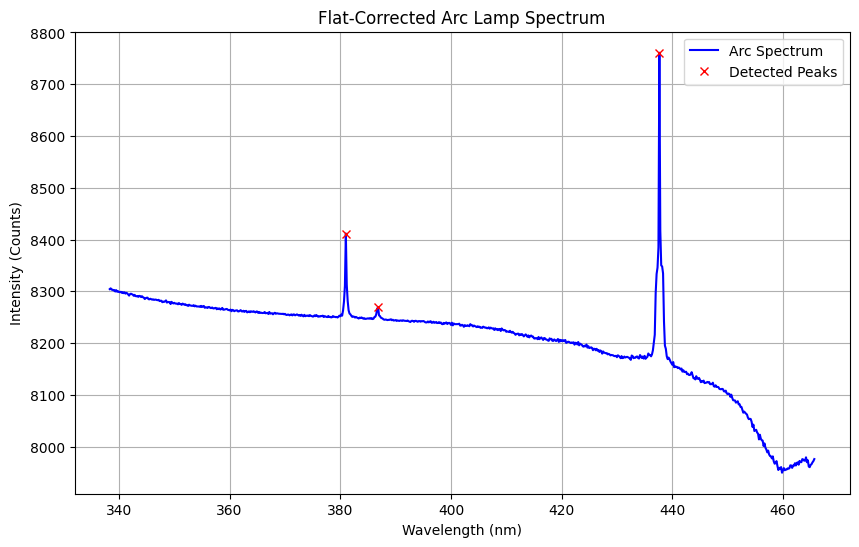

In [4337]:
def process_arc_lamp_spectrum(arc_lamp_spectrum_1d, coefficients, peak_indices):
    """
    Process the arc lamp spectrum by converting to wavelengths and plotting the results.

    :param arc_lamp_spectrum_1d: 1D array containing the arc lamp spectrum (in intensity/counts).
    :type arc_lamp_spectrum_1d: np.ndarray
    :param coefficients: Coefficients of the linear fit for the conversion to nanometers.
    :type coefficients: tuple
    :param peak_indices: Indices of the identified peaks in the spectrum.
    :type peak_indices: np.ndarray
    """
    # Convert the spectrum to wavelengths
    wavelengths, converted_spectrum = convert_dispersion_to_nanometers(arc_lamp_spectrum_1d, coefficients)
    # Plot the flat-corrected arc spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_spectrum, label='Arc Spectrum', color='blue')
    # Mark the peaks with an 'x' symbol
    plt.plot(wavelengths[peak_indices], converted_spectrum[peak_indices], 'x', color='red', label="Detected Peaks")
    # Set plot titles and labels
    plt.title('Flat-Corrected Arc Lamp Spectrum')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.legend()
    plt.grid()
    plt.show()

# Calling the functions 
process_arc_lamp_spectrum(arc_lamp_spectrum_1d, coefficients, peak_indices)
# The peaks aren't equal to [365.02, 404.66, 435.83] expected values but rather [381.007, 386.84, 437.665]

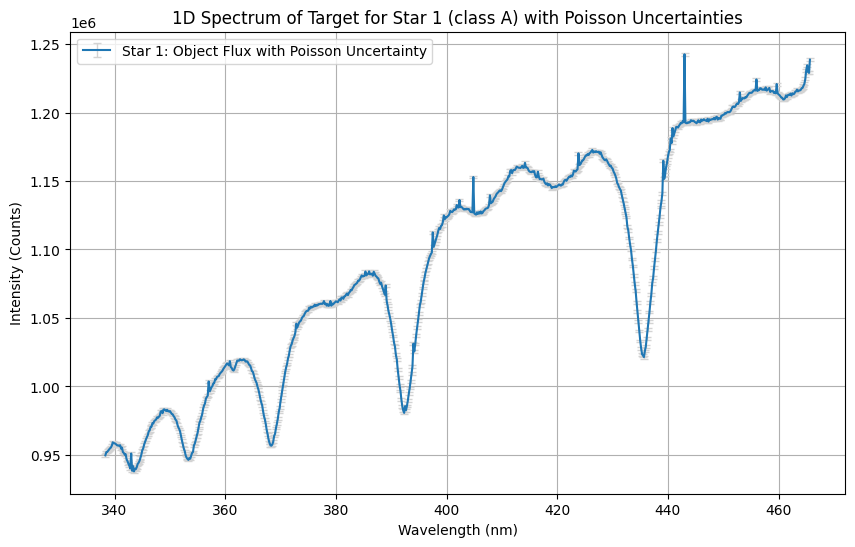

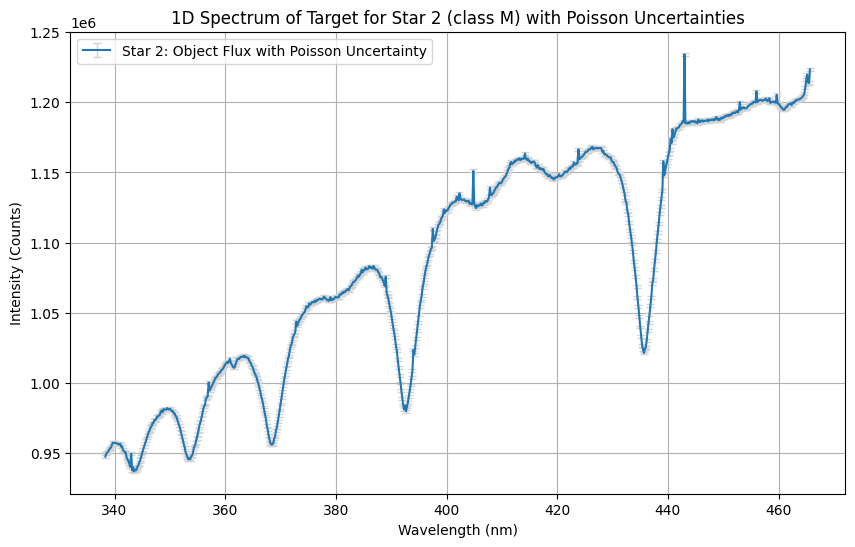

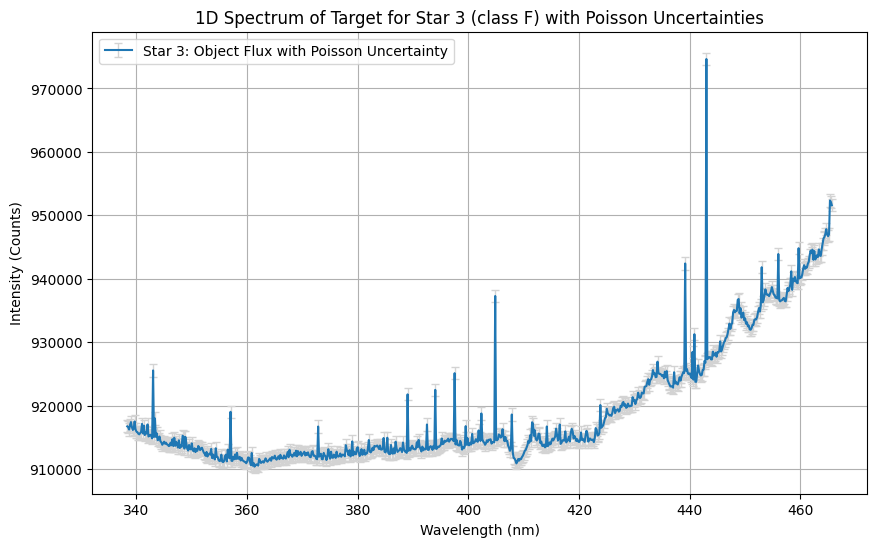

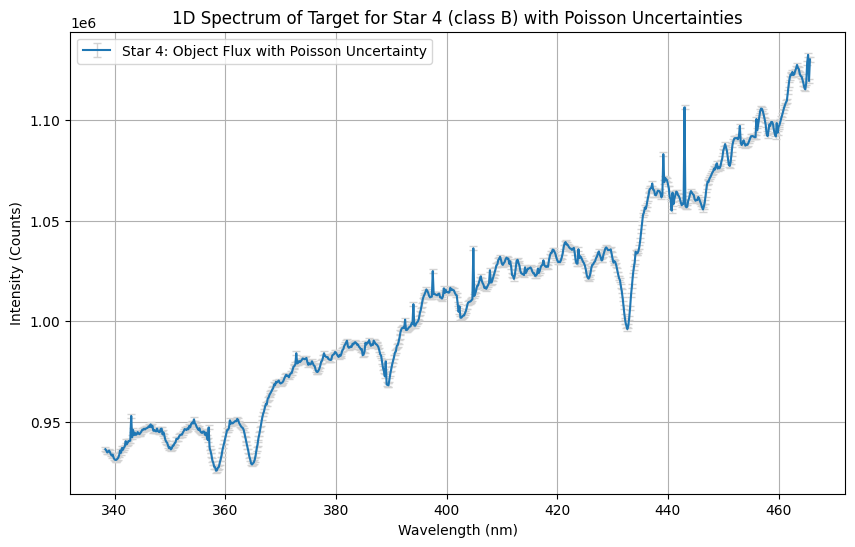

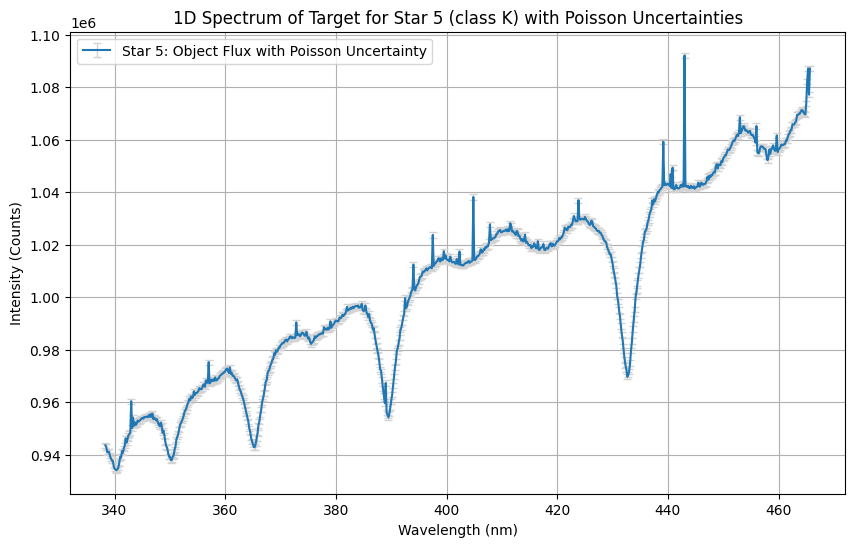

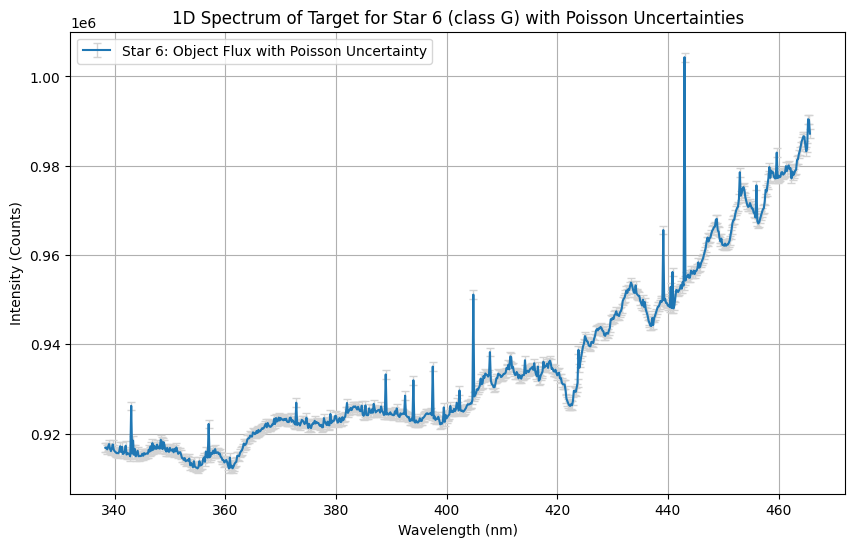

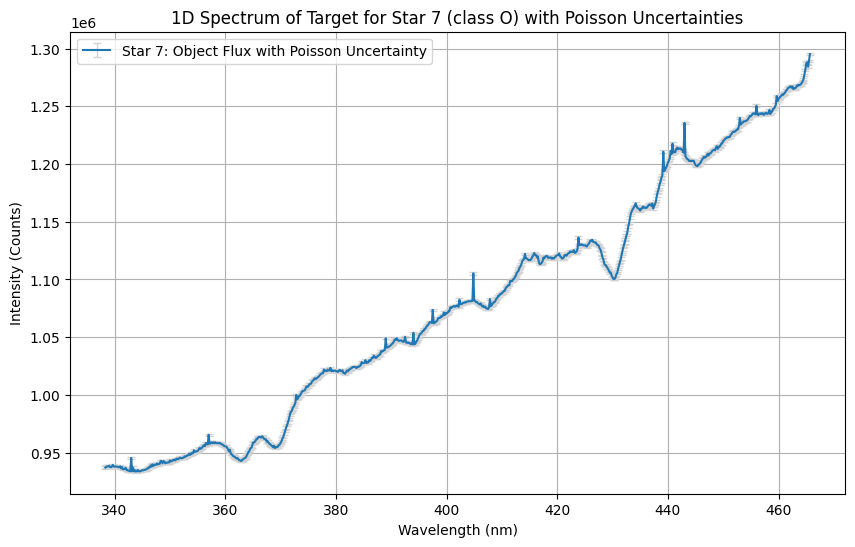

In [4338]:
def process_star_spectra(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Plotting the object flux and its uncertainties for each star
        plt.figure(figsize=(10, 6))
        plt.errorbar(wavelengths, converted_object_flux, yerr=poisson_uncertainties, fmt='-', 
                     label=f'Star {i+1}: Object Flux with Poisson Uncertainty', 
                     ecolor='lightgray', elinewidth=1, capsize=3)  
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'1D Spectrum of Target for Star {i+1} (class {star_classes[i]}) with Poisson Uncertainties')
        plt.legend()
        plt.grid(True)
        plt.show()

process_star_spectra(corrected_spectra_images,coefficients)

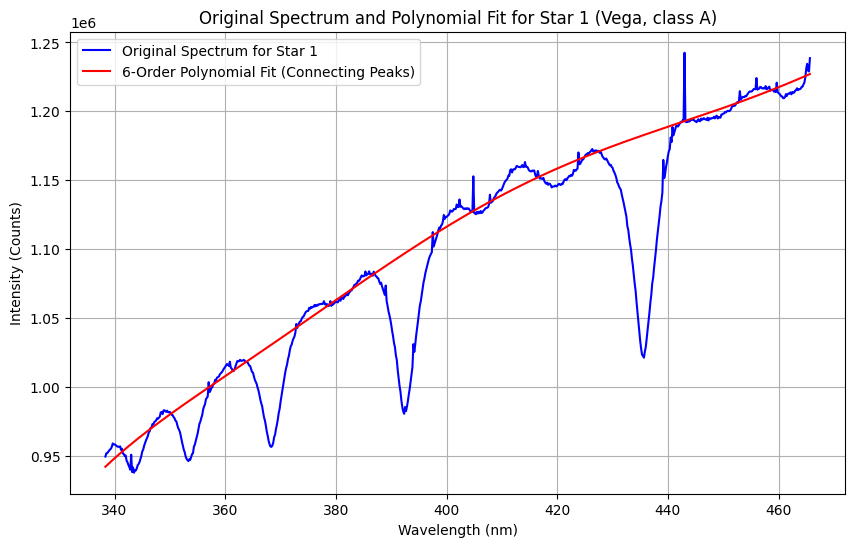

In [4339]:
def process_star_spectra_Vega_Peaks(corrected_spectra_images, coefficients):
    """
    Process the corrected spectra image of the first star, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Process only the first star's corrected spectra image
    corrected_image = corrected_spectra_images[0]
    
    # Extract object and sky flux
    object_flux, sky_flux = extract_target_sky_flux(corrected_image)
    # Calculate Poisson uncertainties
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
    # Convert to wavelengths (nm)
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Plot both the original curve and the polynomial fit for Star 1
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, converted_object_flux, label='Original Spectrum for Star 1', color='blue')
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Original Spectrum and Polynomial Fit for Star 1 (Vega, class A)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return wavelengths, converted_object_flux

# Call the function to get wavelengths and flux for the reference star
wavelengths, converted_object_flux = process_star_spectra_Vega_Peaks(corrected_spectra_images, coefficients)


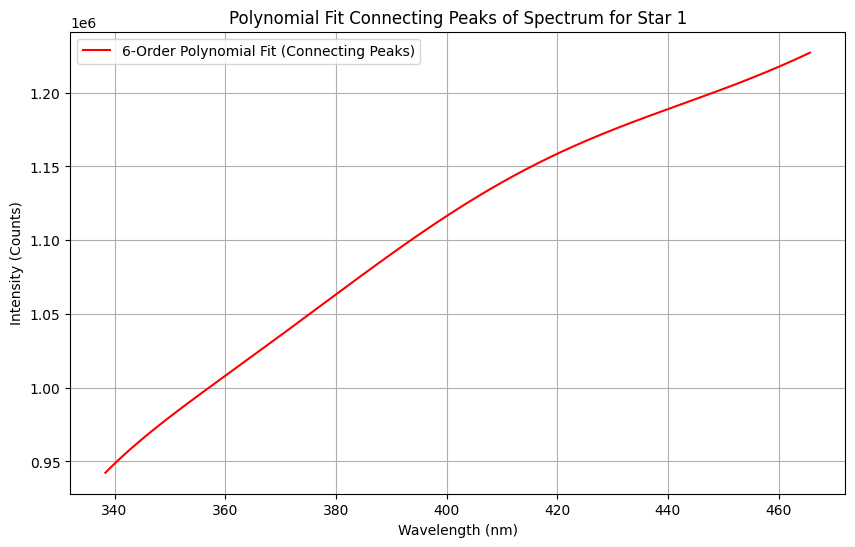

(array([338.34638003, 338.51302121, 338.67966238, 338.84630355,
        339.01294472, 339.17958589, 339.34622707, 339.51286824,
        339.67950941, 339.84615058, 340.01279176, 340.17943293,
        340.3460741 , 340.51271527, 340.67935645, 340.84599762,
        341.01263879, 341.17927996, 341.34592113, 341.51256231,
        341.67920348, 341.84584465, 342.01248582, 342.179127  ,
        342.34576817, 342.51240934, 342.67905051, 342.84569168,
        343.01233286, 343.17897403, 343.3456152 , 343.51225637,
        343.67889755, 343.84553872, 344.01217989, 344.17882106,
        344.34546223, 344.51210341, 344.67874458, 344.84538575,
        345.01202692, 345.1786681 , 345.34530927, 345.51195044,
        345.67859161, 345.84523279, 346.01187396, 346.17851513,
        346.3451563 , 346.51179747, 346.67843865, 346.84507982,
        347.01172099, 347.17836216, 347.34500334, 347.51164451,
        347.67828568, 347.84492685, 348.01156802, 348.1782092 ,
        348.34485037, 348.51149154, 348.

In [4340]:
def process_star_spectra_connected_only(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Plotting the object flux and its uncertainties for each star
        plt.figure(figsize=(10, 6))
        plt.errorbar(wavelengths, converted_object_flux, yerr=poisson_uncertainties, fmt='-', 
                     label=f'Star {i+1}: Object Flux with Poisson Uncertainty', 
                     ecolor='lightgray', elinewidth=1, capsize=3)  
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'1D Spectrum of Target for Star {i+1} with Poisson Uncertainties')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Identify peaks in the original spectrum
        peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
        peak_wavelengths = wavelengths[peak_indices]
        peak_fluxes = converted_object_flux[peak_indices]
        
        # Fit a polynomial to connect most of the peaks
        polynomial_degree = min(4, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
        polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
        fit_values = polynomial_fit(wavelengths)
        
        # Plot the polynomial fit along with the original spectrum
        plt.figure(figsize=(10, 6))
        # plt.plot(wavelengths, converted_object_flux, label=f'Star {i+1}: Original Spectrum', color='blue')
        plt.plot(wavelengths, converted_object_flux, label='Star 1 Original Spectrum', color='blue')
        plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'Polynomial Fit Connecting Peaks of Spectrum for Star {i+1}')
        plt.legend()
        plt.grid(True)
        plt.show()
    """
    
    # Process only the first star
    corrected_image = corrected_spectra_images[0]
    
    # Extract object and sky flux
    object_flux, sky_flux = extract_target_sky_flux(corrected_image)
    # Calculate Poisson uncertainties
    poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
    # Convert to wavelengths (nm)
    wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

    # Identify peaks in the original spectrum
    peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
    peak_wavelengths = wavelengths[peak_indices]
    peak_fluxes = converted_object_flux[peak_indices]
    
    # Fit a polynomial to connect most of the peaks
    polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
    polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
    fit_values = polynomial_fit(wavelengths)
    
    # Plot only the polynomial fit for Star 1
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Polynomial Fit Connecting Peaks of Spectrum for Star 1')
    plt.legend()
    plt.grid(True)
    plt.show()

    return wavelengths, converted_object_flux

# Call the function to get wavelengths and flux for the reference star
process_star_spectra_connected_only(corrected_spectra_images, coefficients)


In [4341]:


def calculate_blackbody_spectrum(wavelengths, temperature):
    """
    #Calculate the blackbody spectrum for a given temperature.

   # :param wavelengths: Wavelengths in nm for which to calculate the spectrum.
    #:type wavelengths: np.ndarray
   # :param temperature: Temperature of the blackbody in Kelvin.
   # :type temperature: float
    #:return: Blackbody spectrum.
    #:rtype: np.ndarray
    #"""
    # Convert wavelengths from nm to meters for the calculation
    wavelengths_m = wavelengths * 1e-9
    # Planck's constant (h), speed of light (c), and Boltzmann constant (k)
    # h = 6.626e-34
    # c = 3.0e8
    # k = 1.38e-23

    # Calculate the blackbody radiation using Planck's law
    term1 = (2.0 * h * c**2) / (wavelengths_m**5)
    term2 = 1.0 / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)
    blackbody_spectrum = term1 * term2


    return blackbody_spectrum

# Plot the theoretical function

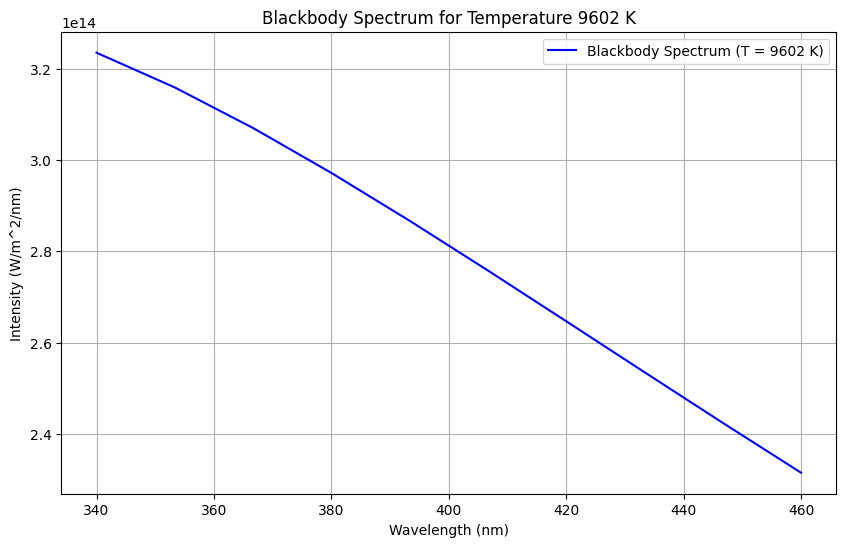

In [4342]:
def plot_blackbody_spectrum(wavelengths, temperature):
    """
    Plot the blackbody spectrum for a given temperature.

    :param wavelengths: Wavelengths in nm for which to calculate the spectrum.
    :type wavelengths: np.ndarray
    :param temperature: Temperature of the blackbody in Kelvin.
    :type temperature: float
    """
    # Calculate the blackbody spectrum
    blackbody_spectrum = calculate_blackbody_spectrum(wavelengths, temperature)
    
    # Plotting the blackbody spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, blackbody_spectrum, label=f'Blackbody Spectrum (T = {temperature} K)', color='blue')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (W/m^2/nm)')
    plt.title(f'Blackbody Spectrum for Temperature {temperature} K')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
wavelengths = np.linspace(340,460,10)  # Wavelengths from 100 nm to 3000 nm
plot_blackbody_spectrum(wavelengths, 9602)  # Plot for a temperature of 5778 K

In [4343]:
def plot_blackbody_spectrum_A(temperature=9602, wavelength_range=(340,460)):
    """
    Plot the blackbody spectrum for a given temperature.

    :param temperature: Temperature of the blackbody in Kelvin (default is 5778 K).
    :type temperature: float
    :param wavelength_range: Tuple representing the range of wavelengths in Angstroms (default is (1000, 110000)).
    :type wavelength_range: tuple
    """
    # Calculate the blackbody spectrum
    wav, flux = calculate_blackbody_spectrum(temperature, wavelength_range)

    # Plotting the blackbody spectrum
    with quantity_support():
        plt.figure()
        plt.semilogx(wav, flux)
        plt.axvline(BlackBody(temperature=temperature * u.K).nu_max.to(u.AA, equivalencies=u.spectral()).value, ls='--', color='red', label='Peak Wavelength')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Flux (W/m^2/Hz)')
        plt.title(f'Blackbody Spectrum for T = {temperature} K')
        plt.legend()
        plt.grid(True)
        plt.show()

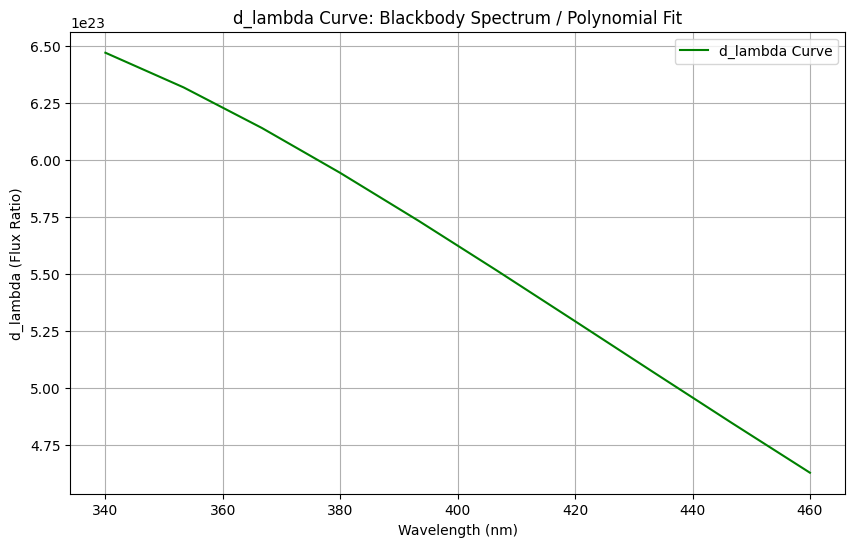

(array([340.        , 353.33333333, 366.66666667, 380.        ,
        393.33333333, 406.66666667, 420.        , 433.33333333,
        446.66666667, 460.        ]),
 array([6.47009642e+23, 6.31798691e+23, 6.14011424e+23, 5.94338710e+23,
        5.73362057e+23, 5.51563563e+23, 5.29337248e+23, 5.07000607e+23,
        4.84805667e+23, 4.62949158e+23]))

In [4344]:
def calculate_d_lambda(wavelengths, temperature, polynomial_coefficients, wavelength_range=(340, 460)):
    """
    Calculate the d_lambda curve by dividing the blackbody spectrum by the polynomial fit.

    :param wavelengths: Wavelengths in nm for which to calculate the spectrum.
    :type wavelengths: np.ndarray
    :param temperature: Temperature of the blackbody in Kelvin.
    :type temperature: float
    :param polynomial_coefficients: Coefficients of the fitted polynomial.
    :type polynomial_coefficients: np.ndarray
    :param wavelength_range: Range of wavelengths in nm for which to calculate d_lambda.
    :type wavelength_range: tuple
    :return: Wavelengths and corresponding d_lambda values.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Filter wavelengths within the specified range
    mask = (wavelengths >= wavelength_range[0]) & (wavelengths <= wavelength_range[1])
    wavelengths_filtered = wavelengths[mask]
    
    # Calculate the blackbody spectrum for the filtered wavelength range
    blackbody_spectrum = calculate_blackbody_spectrum(wavelengths_filtered, temperature)
    
    # Evaluate the polynomial fit over the filtered wavelength range
    polynomial_fit = Polynomial(polynomial_coefficients)
    fitted_values = polynomial_fit(wavelengths_filtered)
    
    # Calculate d_lambda by dividing the blackbody flux by the polynomial fit values
    d_lambda = blackbody_spectrum / fitted_values
    
    # Plot the d_lambda curve
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths_filtered, d_lambda, label='d_lambda Curve', color='green')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('d_lambda (Flux Ratio)')
    plt.title('d_lambda Curve: Blackbody Spectrum / Polynomial Fit')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return wavelengths_filtered, d_lambda

# Example usage
wavelengths = np.linspace(340, 460, 10)  # Wavelengths from 340 nm to 460 nm
polynomial_coefficients = [5e-10]  # Coefficients
calculate_d_lambda(wavelengths, 9602, polynomial_coefficients, wavelength_range=(340, 460))


In [4345]:
def calculate_d_lambda_no_plot(wavelengths, temperature, polynomial_coefficients, wavelength_range=(340, 460)):
    """
    Calculate the d_lambda but does not show the curve by dividing the blackbody spectrum by the polynomial fit.

    :param wavelengths: Wavelengths in nm for which to calculate the spectrum.
    :type wavelengths: np.ndarray
    :param temperature: Temperature of the blackbody in Kelvin.
    :type temperature: float
    :param polynomial_coefficients: Coefficients of the fitted polynomial.
    :type polynomial_coefficients: np.ndarray
    :param wavelength_range: Range of wavelengths in nm for which to calculate d_lambda.
    :type wavelength_range: tuple
    :return: Wavelengths and corresponding d_lambda values.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    # Filter wavelengths within the specified range
    mask = (wavelengths >= wavelength_range[0]) & (wavelengths <= wavelength_range[1])
    wavelengths_filtered = wavelengths[mask]
    
    # Calculate the blackbody spectrum for the filtered wavelength range
    blackbody_spectrum = calculate_blackbody_spectrum(wavelengths_filtered, temperature)
    
    # Evaluate the polynomial fit over the filtered wavelength range
    polynomial_fit = Polynomial(polynomial_coefficients)
    fitted_values = polynomial_fit(wavelengths_filtered)
    
    # Calculate d_lambda by dividing the blackbody flux by the polynomial fit values
    d_lambda = blackbody_spectrum / fitted_values

    return wavelengths_filtered, d_lambda

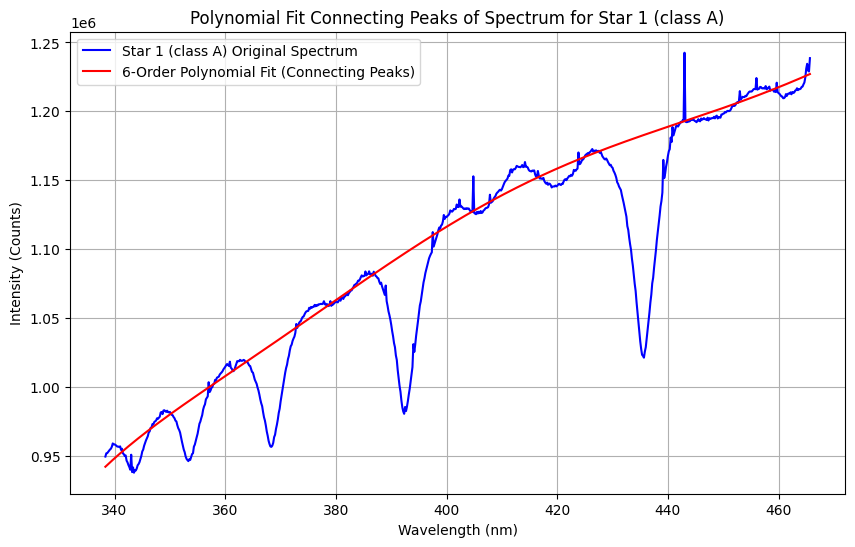

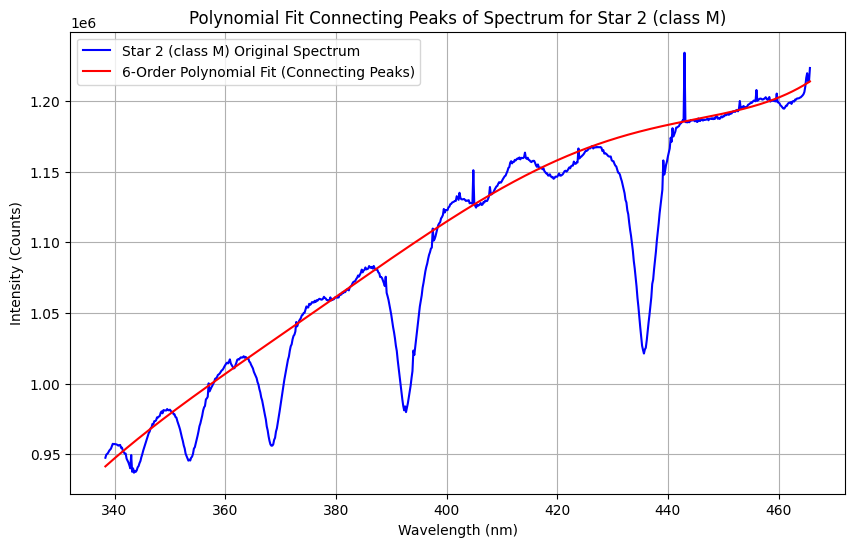

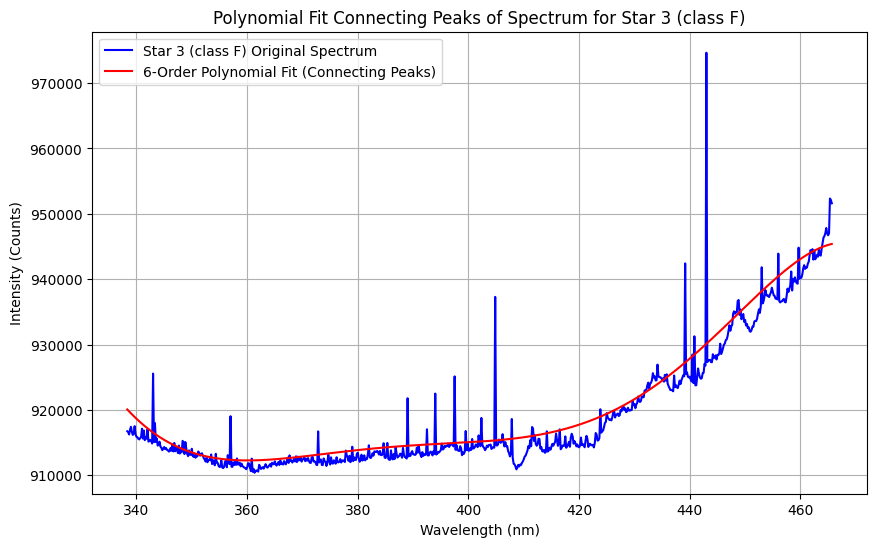

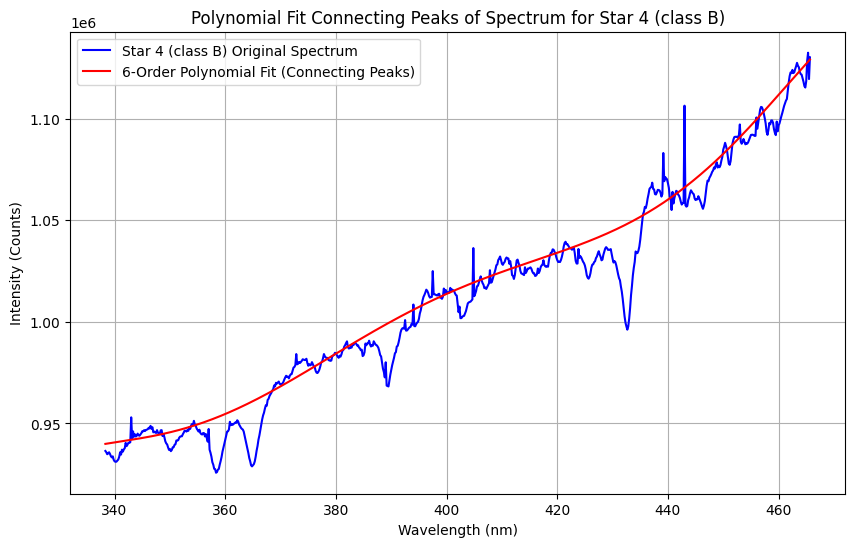

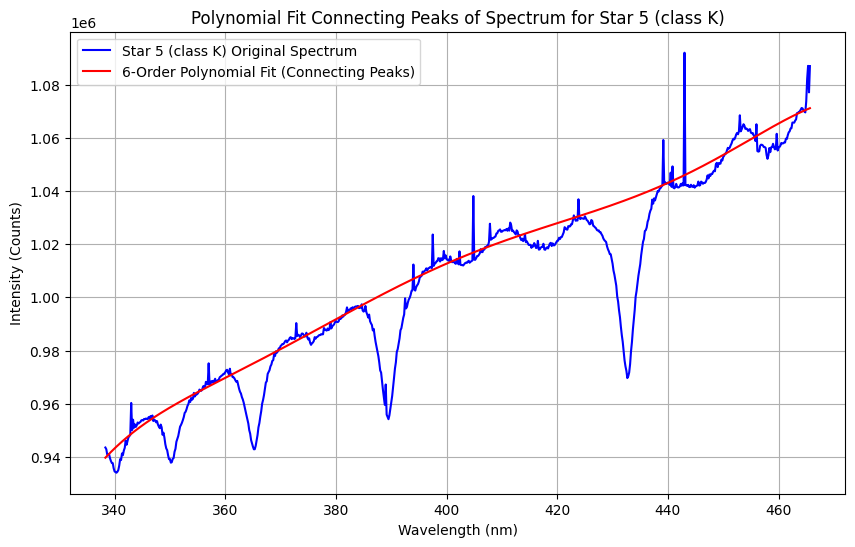

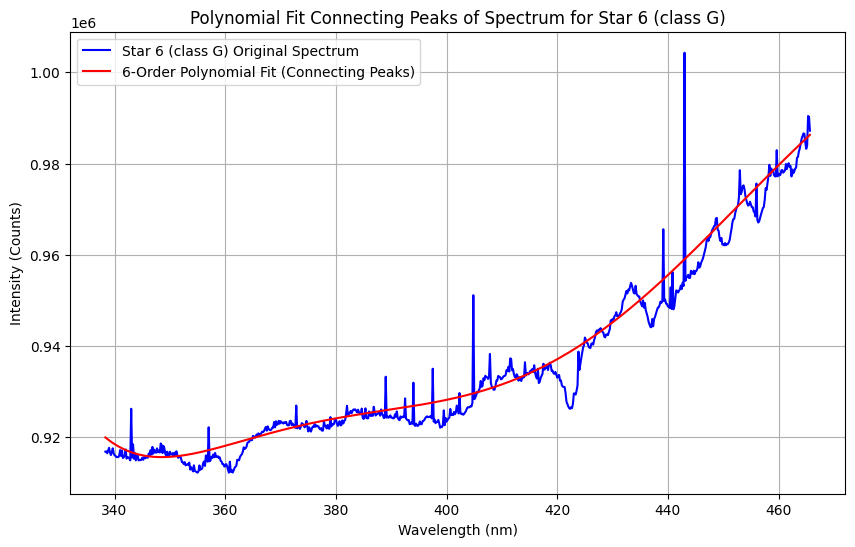

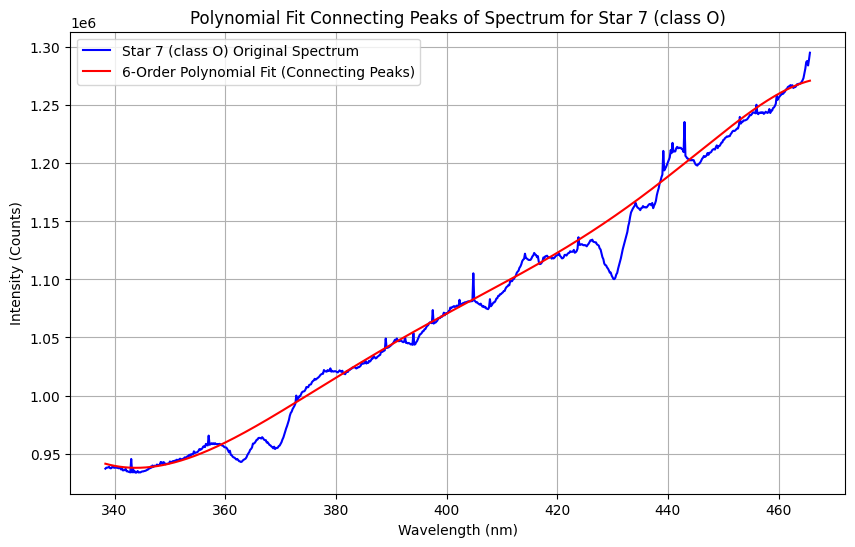

In [4346]:
def process_star_spectra_all_interpolation(corrected_spectra_images, coefficients):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :return: Wavelengths and converted object flux of the reference star.
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)
        
        # Identify peaks in the original spectrum
        peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
        peak_wavelengths = wavelengths[peak_indices]
        peak_fluxes = converted_object_flux[peak_indices]
        
        # Fit a polynomial to connect most of the peaks
        polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
        polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
        fit_values = polynomial_fit(wavelengths)
        
        # Plot the polynomial fit along with the original spectrum
        plt.figure(figsize=(10, 6))
        plt.plot(wavelengths, converted_object_flux, label=f'Star {i+1} (class {star_classes[i]}) Original Spectrum', color='blue')
        plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'Polynomial Fit Connecting Peaks of Spectrum for Star {i+1} (class {star_classes[i]})')
        plt.legend()
        plt.grid(True)
        plt.show()

process_star_spectra_all_interpolation(corrected_spectra_images, coefficients)

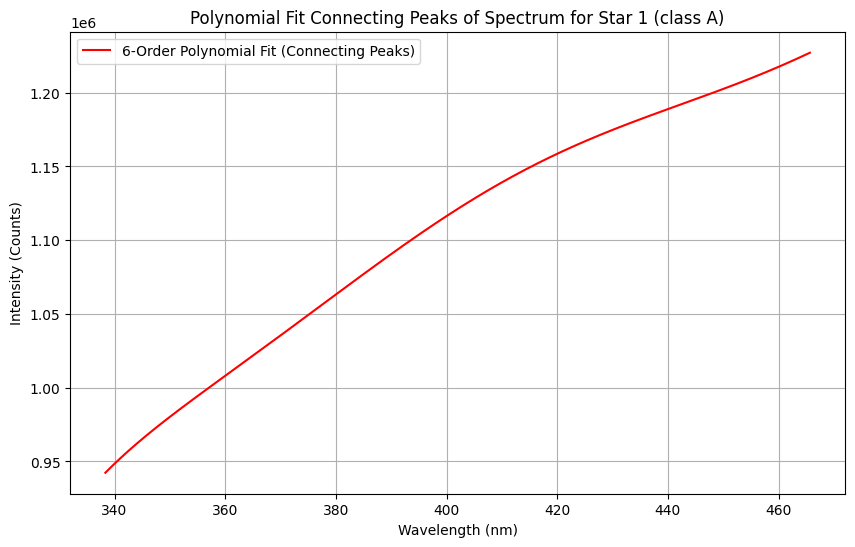

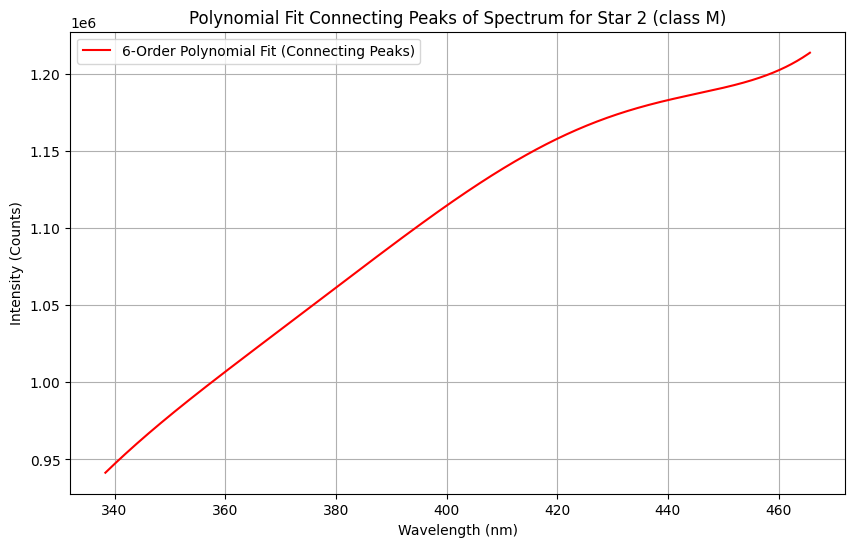

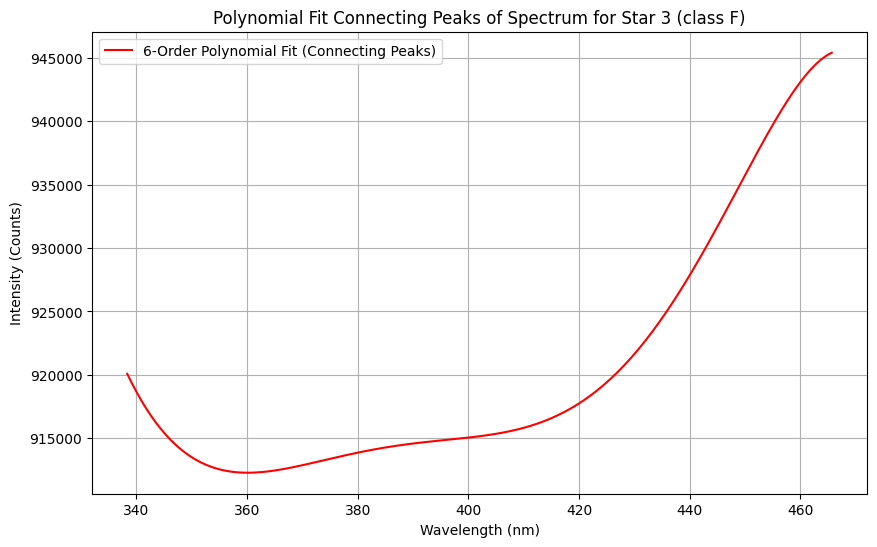

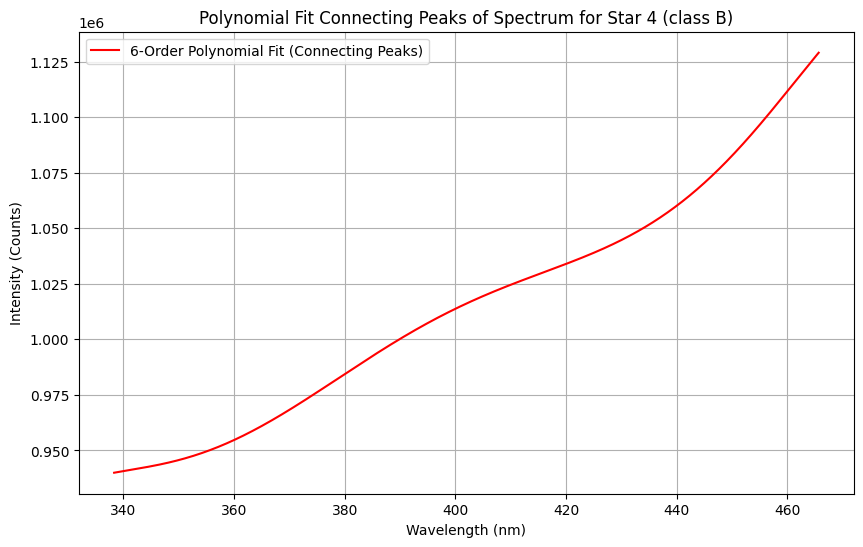

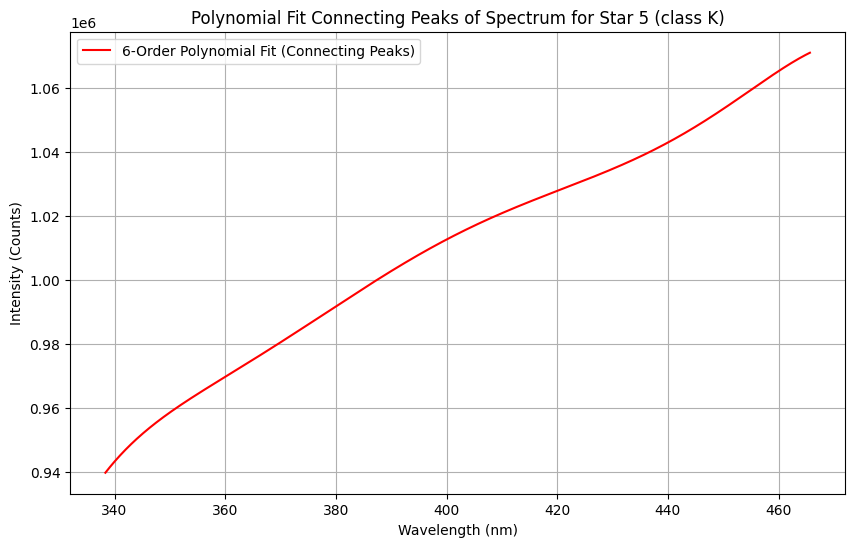

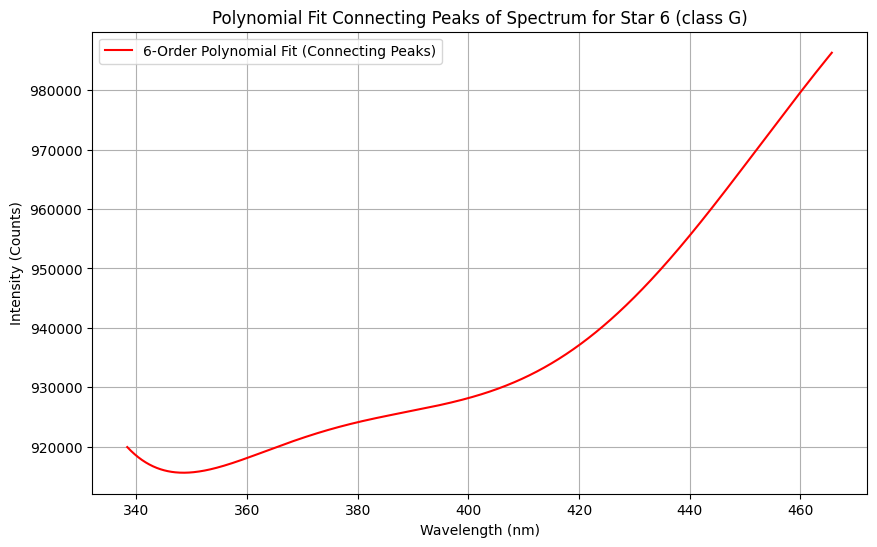

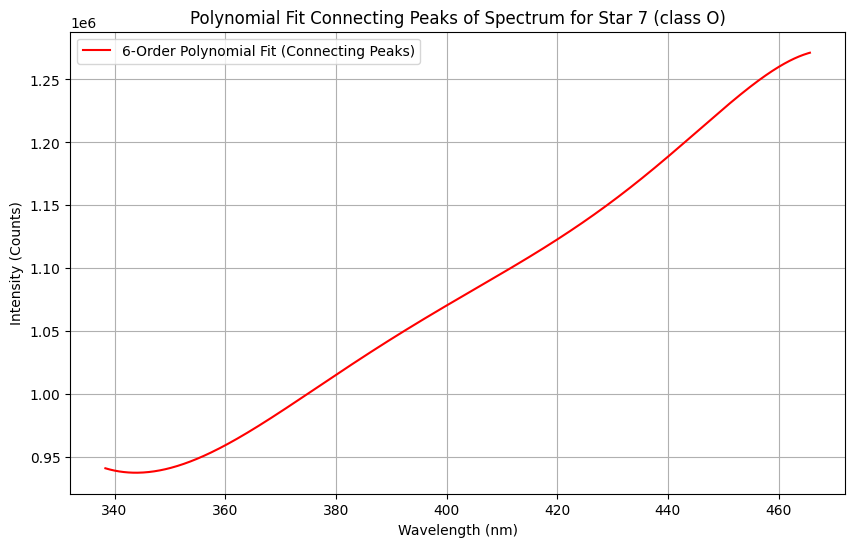

In [4347]:
def process_star_spectra_red_line(corrected_spectra_images, coefficients):
    # Process each star's corrected spectra image, calculate flux and uncertainties,
    # convert to wavelengths, and save plots. Returns the converted object flux for further analysis.

    # :param corrected_spectra_images: List of corrected spectra images for stars.
    # :type corrected_spectra_images: list of np.ndarray
    # :param coefficients: Coefficients of the linear fit for wavelength conversion.
    # :type coefficients: tuple
    # :return: Wavelengths and converted object flux of the reference star.
    # :rtype: tuple(np.ndarray, np.ndarray)
    
    star_classes = ['A', 'M', 'F', 'B', 'K', 'G', 'O']
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Plotting the object flux and its uncertainties for each star
        #plt.figure(figsize=(10, 6))
        #plt.errorbar(wavelengths, converted_object_flux, yerr=poisson_uncertainties, fmt='-', 
        #             label=f'Star {i+1}: Object Flux with Poisson Uncertainty', 
        #             ecolor='lightgray', elinewidth=1, capsize=3)  
        #plt.xlabel('Wavelength (nm)')
        #plt.ylabel('Intensity (Counts)')
        #plt.title(f'1D Spectrum of Target for Star {i+1} with Poisson Uncertainties')
        #plt.legend()
        #plt.grid(True)
        #plt.show()
        
        # Identify peaks in the original spectrum
        peak_indices, _ = find_peaks(converted_object_flux, prominence=10)  # Adjust prominence as needed
        peak_wavelengths = wavelengths[peak_indices]
        peak_fluxes = converted_object_flux[peak_indices]
        
        # Fit a polynomial to connect most of the peaks
        polynomial_degree = min(6, len(peak_wavelengths) - 1)  # Ensure polynomial degree is suitable for number of peaks
        polynomial_fit = Polynomial.fit(peak_wavelengths, peak_fluxes, deg=polynomial_degree)
        fit_values = polynomial_fit(wavelengths)
        
        # Plot the polynomial fit along with the original spectrum
        plt.figure(figsize=(10, 6))
        # plt.plot(wavelengths, converted_object_flux, label=f'Star {i+1}: Original Spectrum', color='blue')
        # plt.plot(wavelengths, converted_object_flux, label='Star 1 Original Spectrum', color='blue')
        plt.plot(wavelengths, fit_values, label=f'{polynomial_degree}-Order Polynomial Fit (Connecting Peaks)', color='red')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'Polynomial Fit Connecting Peaks of Spectrum for Star {i+1} (class {star_classes[i]})')
        plt.legend()
        plt.grid(True)
        plt.show()

process_star_spectra_red_line(corrected_spectra_images, coefficients)

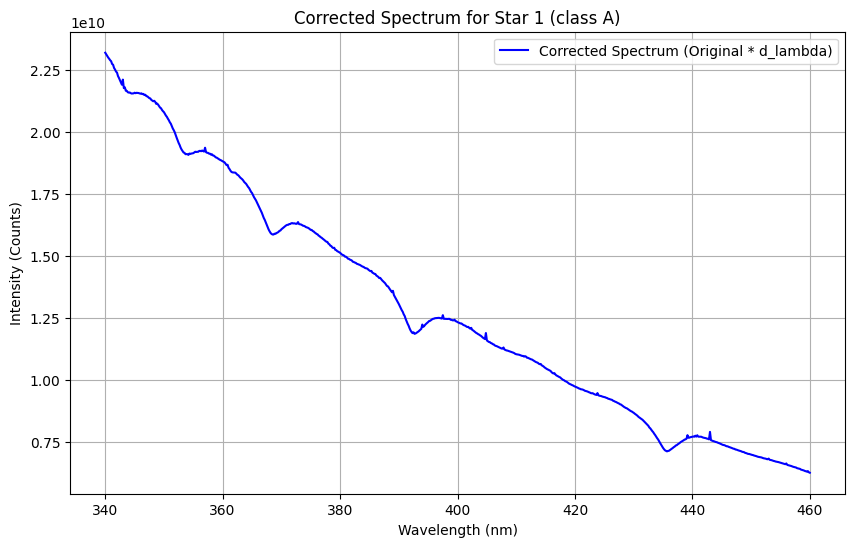

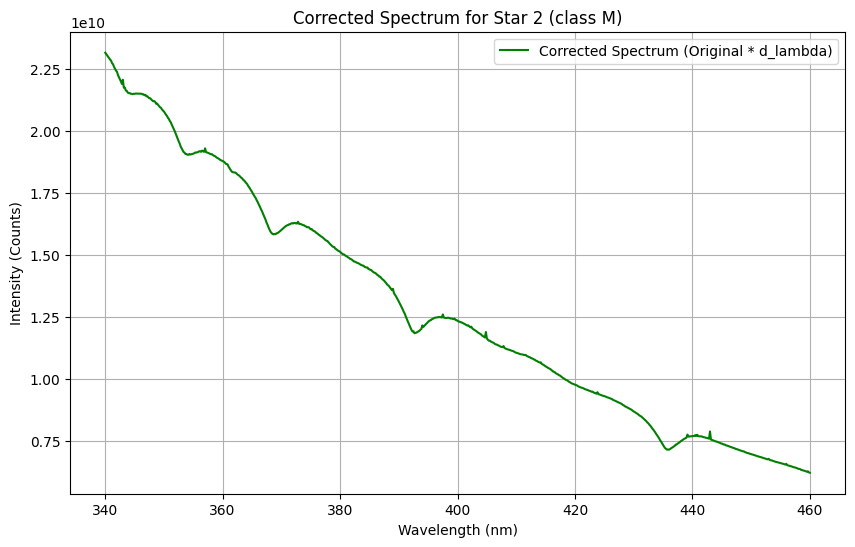

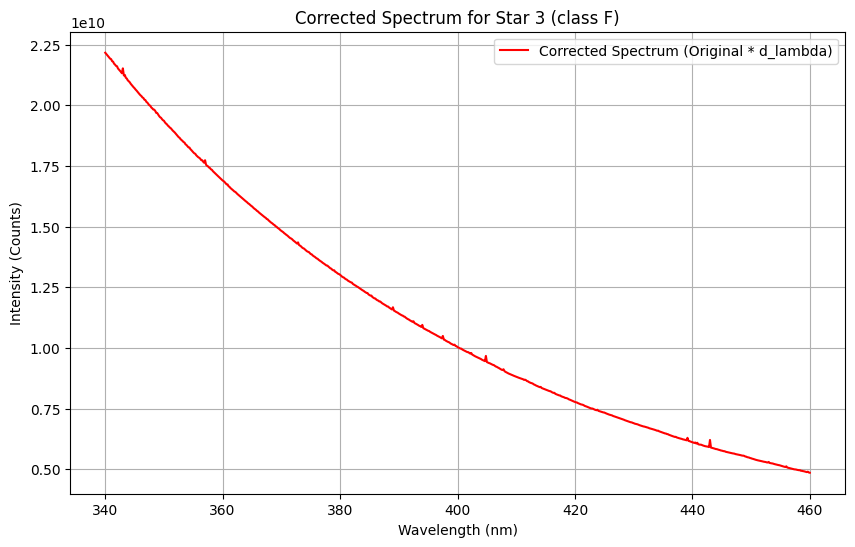

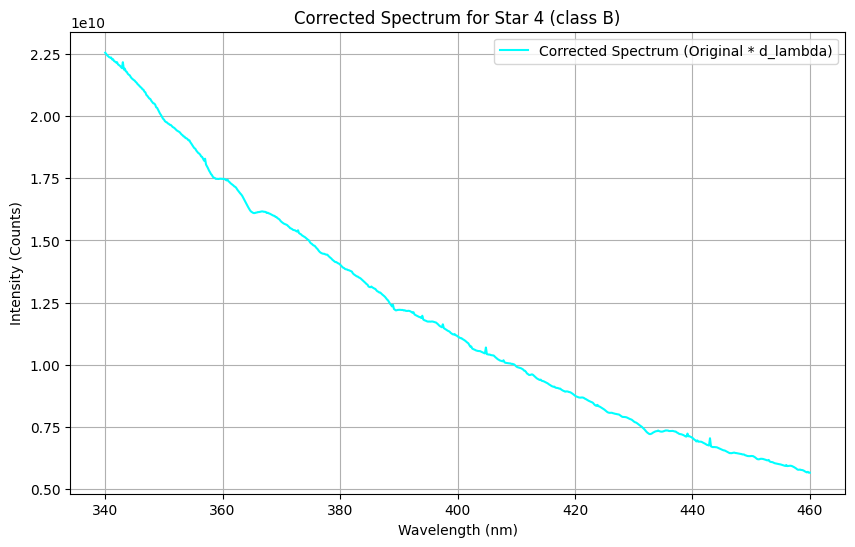

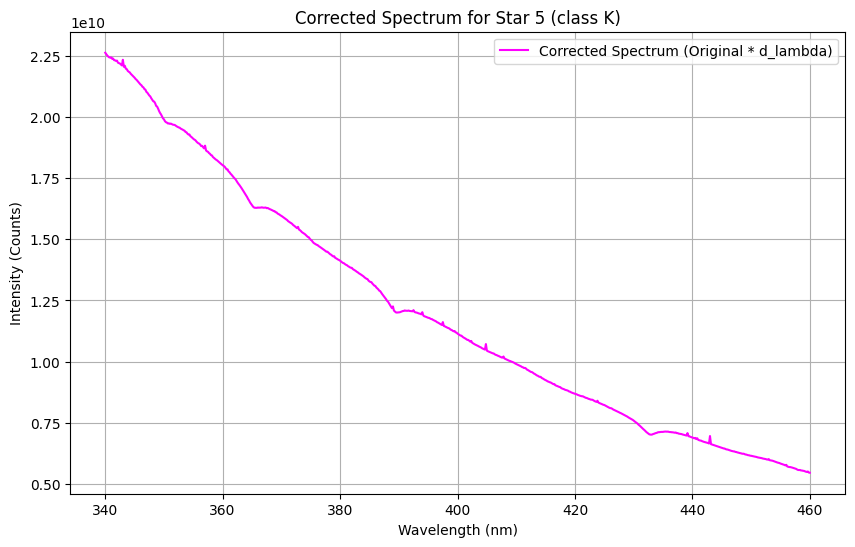

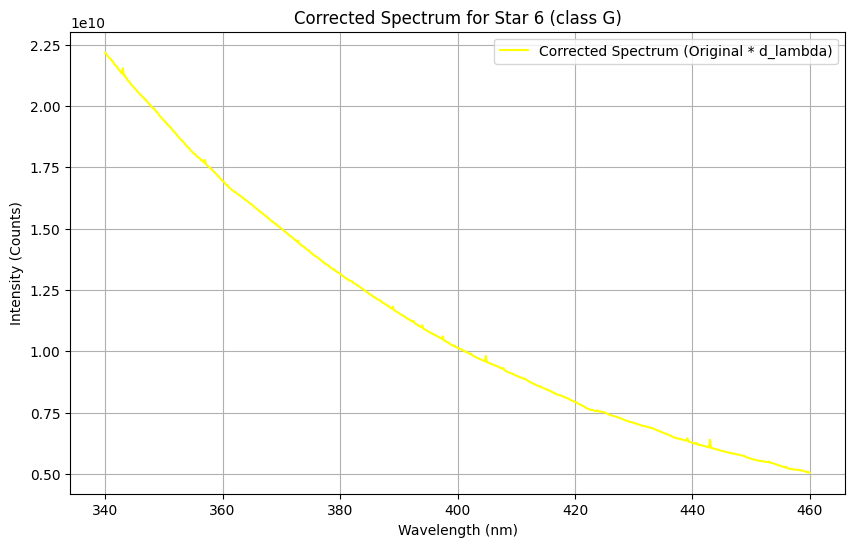

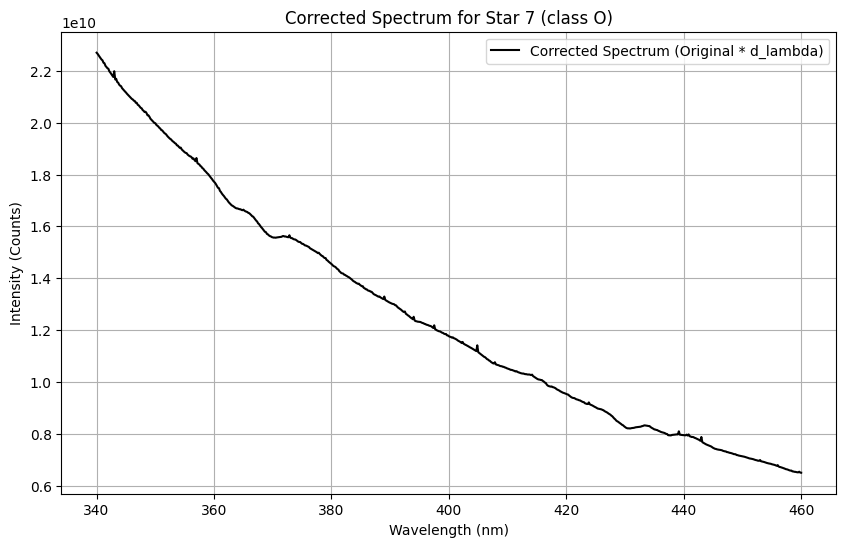

In [4348]:

def process_star_spectra_red_line(corrected_spectra_images, coefficients, temperature, polynomial_coefficients, wavelength_range=(340, 460)):
    """
    Process each star's corrected spectra image, calculate flux and uncertainties,
    convert to wavelengths, multiply the original spectrum with d_lambda, and plot the results.

    :param corrected_spectra_images: List of corrected spectra images for stars.
    :type corrected_spectra_images: list of np.ndarray
    :param coefficients: Coefficients of the linear fit for wavelength conversion.
    :type coefficients: tuple
    :param temperature: Temperature of the blackbody in Kelvin.
    :type temperature: float
    :param polynomial_coefficients: Coefficients of the fitted polynomial.
    :type polynomial_coefficients: np.ndarray
    :param wavelength_range: Range of wavelengths in nm for which to calculate d_lambda.
    :type wavelength_range: tuple
    """
    corrected_spectra_list = []
    wavelengths_filtered_list = []
    star_classes = ['A','M','F','B','K','G','O']
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for i, corrected_image in enumerate(corrected_spectra_images):
        # Extract object and sky flux
        object_flux, sky_flux = extract_target_sky_flux(corrected_image)
        # Calculate Poisson uncertainties
        poisson_uncertainties = calculate_poisson_uncertainties(object_flux, sky_flux)
        # Convert to wavelengths (nm)
        wavelengths, converted_object_flux = convert_dispersion_to_nanometers(object_flux, coefficients)

        # Calculate d_lambda for the specified wavelength range
        wavelengths_filtered, d_lambda = calculate_d_lambda_no_plot(wavelengths, temperature, polynomial_coefficients, wavelength_range=wavelength_range)

        # Multiply the original spectrum with d_lambda to get the corrected spectrum
        mask = (wavelengths >= wavelength_range[0]) & (wavelengths <= wavelength_range[1])
        corrected_spectrum = converted_object_flux[mask] * d_lambda

        # Store corrected spectrum and filtered wavelengths for later use
        corrected_spectra_list.append(corrected_spectrum)
        wavelengths_filtered_list.append(wavelengths_filtered)

        # Plot the corrected spectrum
        plt.figure(figsize=(10, 6))
        plt.plot(wavelengths_filtered, corrected_spectrum, label='Corrected Spectrum (Original * d_lambda)', color=f'{colors[i]}')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Intensity (Counts)')
        plt.title(f'Corrected Spectrum for Star {i+1} (class {star_classes[i]})')
        plt.legend()
        plt.grid(True)
        plt.show()

    return wavelengths_filtered_list, corrected_spectra_list

wavelengths_filtered_list, corrected_spectra_list = process_star_spectra_red_line(corrected_spectra_images, coefficients, temperature=9602, polynomial_coefficients=[1e-17, -1e-13, 5e-10, -1e-6, 1], wavelength_range=(340, 460))




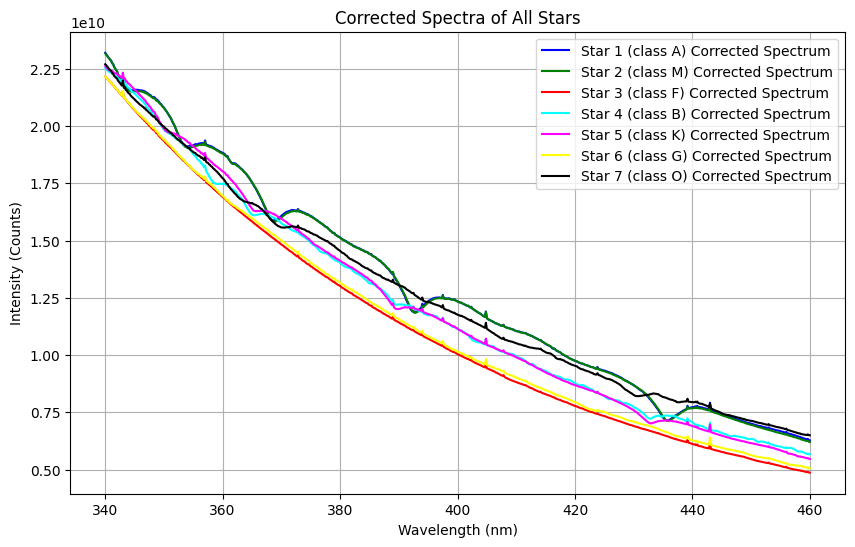

In [4349]:
def plot_all_corrected_spectra(wavelengths_filtered_list, corrected_spectra_list):
    """
    Plot the corrected spectra of all stars on a single graph, each in a different color.

    :param wavelengths_filtered_list: List of wavelength arrays for each star's corrected spectrum.
    :type wavelengths_filtered_list: list of np.ndarray
    :param corrected_spectra_list: List of corrected spectra for each star.
    :type corrected_spectra_list: list of np.ndarray
    """
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    classes = ['A','M','F','B','K','G','O']
    plt.figure(figsize=(10, 6))
    for i, (wavelengths_filtered, corrected_spectrum) in enumerate(zip(wavelengths_filtered_list, corrected_spectra_list)):
        plt.plot(wavelengths_filtered, corrected_spectrum, label=f'Star {i+1} (class {classes[i]}) Corrected Spectrum', color=colors[i % len(colors)])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (Counts)')
    plt.title('Corrected Spectra of All Stars')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage

plot_all_corrected_spectra(wavelengths_filtered_list, corrected_spectra_list)